In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
project_dir = "/ssd-home/pinkaew/research/scouting-performance"
sys.path.append(project_dir) # append project directory to path for import
os.chdir(project_dir) # change current working directory to project directory

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import dask
from dask.diagnostics import ProgressBar

import uproot
import awkward as ak
import dask_awkward as dak

import hist
import hist.dask as hda

import mplhep as hep

import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor as coffea_processor
from coffea import util as coffea_util
from coffea import dataset_tools
    #apply_to_fileset,
    #max_chunks,
    #preprocess,

from processor.util import *

import json
from dataclasses import dataclass, field

In [4]:
# progress bar for dask
pbar = ProgressBar()
pbar.register()

In [67]:
plt.style.use(hep.style.CMS)

#hep_args = {'label': 'Preliminary', 'loc': 0, 'data': False, 'year': '2022', 'rlabel': '(13.6 TeV)'}
#hep_args = {'loc': 2, 'data': False, 'year': '2022', 'rlabel': '(13.6 TeV)'}
#hep_args = {'label': 'Private Work', 'loc': 1, 'data': True, 'year': '2023D, 2024BCDE', 'com': 13.6}
hep_args = {'label': "Preliminary", 'loc': 1, 'data': True, 'com': 13.6}

lumi_E_v1 = 6.279523314
lumi_E_v2 = 5.040339852
lumi_E = lumi_E_v1 + lumi_E_v2
lumi_F = 24.433843472
lumi_G = 5.083251048

hep_args['year'] = "2024G"
#hep_args['year'] = "2024D(%s fb$^{-1}$)+E(%s fb$^{-1}$)"%(f"{lumi_E:.2f}", f"{lumi_F:.2f}")
#hep_args['rlabel'] = hep_args['year']

In [6]:
from coffea.nanoevents import NanoAODSchema

class ScoutingNanoAODSchema(NanoAODSchema):
    
    mixins = {
        **NanoAODSchema.mixins,
        "PFJet": "Jet",
        "ScoutingPFJet": "Jet",
        "ScoutingPFJetRecluster": "Jet",
        "ScoutingCHSJetRecluster": "Jet",
        "ScoutingFatCHSJetRecluster": "FatJet",
        "ScoutingRho": "Rho",
        "ScoutingMET": "MissingET",
        "ScoutingMuon": "Muon",
        "ScoutingMuonNoVtx" : "Muon",
        "ScoutingMuonVtx" : "Muon",
        # JMENano
        "JetCHS" : "Jet",
    }

In [7]:
fname = "/ssd-home/pinkaew/research/scouting_performance/scouting_nano_98.root"

In [8]:
events = NanoEventsFactory.from_root(
            {fname: "Events"},
            schemaclass=ScoutingNanoAODSchema,
            metadata={
                "dataset": "test",
            },
            #delayed=False,
            ).events()

/ssd-home/pinkaew/miniconda3/envs/coffea-202x/lib/python3.12/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [9]:
#events["ScoutingPFJet"]

In [10]:
pt_bins = np.array([0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
         180.,  200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,
         360.,  380.,  400., 450., 500., 600., 800, 1000, 1200, 1400, 1800])

pt_bins = np.array([0., 20., 40.,   50, 60.,  70, 80., 90, 100., 110, 120.,  130, 140., 150, 160.,
         170, 180.,  190, 200.,  210, 220., 230, 240., 250, 260., 280., 300.,  320., 340.,
         360., 380.,  400., 450., 500., 600., 800, 1000, 1200, 1400, 1800])

ht_bins = np.array([0., 20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
         180.,  200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,
         360.,  380.,  400., 450., 500., 600., 700, 800, 900, 1000, 1200, 1400, 1800, 2000, 2500, 3000])

In [11]:
def split_trigger(trigger):
    bool_operators = ["OR", "AND", "|", "||", "&", "&&"]
    return [token for token in trigger.split() if token not in bool_operators]

In [12]:
# not sure
@dataclass
class TriggerTask:
    signal_trigger: dict = field(default_factory = lambda: {"name": None, "label": None})
    reference_trigger: dict = field(default_factory = lambda: {"name": None, "label": None})

In [13]:
# processor
# selection
# output

In [14]:
"L1_HTT200er OR L1_HTT255er OR L1_HTT280er OR L1_HTT320er OR L1_HTT360er OR L1_HTT400er OR L1_HTT450er OR L1_ETT2000 OR L1_SingleJet180 OR L1_SingleJet200 OR L1_DoubleJet30er2p5_Mass_Min250_dEta_Max1p5 OR L1_DoubleJet30er2p5_Mass_Min300_dEta_Max1p5 OR L1_DoubleJet30er2p5_Mass_Min330_dEta_Max1p5"

'L1_HTT200er OR L1_HTT255er OR L1_HTT280er OR L1_HTT320er OR L1_HTT360er OR L1_HTT400er OR L1_HTT450er OR L1_ETT2000 OR L1_SingleJet180 OR L1_SingleJet200 OR L1_DoubleJet30er2p5_Mass_Min250_dEta_Max1p5 OR L1_DoubleJet30er2p5_Mass_Min300_dEta_Max1p5 OR L1_DoubleJet30er2p5_Mass_Min330_dEta_Max1p5'

In [15]:
trigger_task = {
    "signal_trigger": {
        "name": "DST_PFScouting_JetHT",
        "label": "auto"
    },
    "reference_trigger": {
        "name": "HLT_IsoMu27 OR HLT_Mu50",
        "label": "auto"
    }
}

trigger_tasks = [
    {
        "signal": {"name": "DST_PFScouting_JetHT"},
        "reference": {"name": "HLT_IsoMu27 OR HLT_Mu50"},
    },
    {
        "signal": {"name": "L1_SingleJet180"},
        "reference": {"name": "HLT_IsoMu27 OR HLT_Mu50"},
    },
    {
        "signal": {"name": "L1_SingleJet200"},
        "reference": {"name": "HLT_IsoMu27 OR HLT_Mu50"},
    },
    {
        "signal": {"name": "L1_HTT200er"},
        "reference": {"name": "HLT_IsoMu27 OR HLT_Mu50"},
    },
    {
        "signal": {"name": "L1_HTT200er"},
        "reference": {"name": "HLT_IsoMu27 OR HLT_Mu50"},
    },
    {
        "signal": {"name": "L1_HTT255er"},
        "reference": {"name": "HLT_IsoMu27 OR HLT_Mu50"},
    },
    {
        "signal": {"name": "L1_HTT280er"},
        "reference": {"name": "HLT_IsoMu27 OR HLT_Mu50"},
    },
    {
        "signal": {"name": "L1_HTT320er"},
        "reference": {"name": "HLT_IsoMu27 OR HLT_Mu50"},
    },
    {
        "signal": {"name": "L1_HTT360er"},
        "reference": {"name": "HLT_IsoMu27 OR HLT_Mu50"},
    },
    {
        "signal": {"name": "L1_HTT400er"},
        "reference": {"name": "HLT_IsoMu27 OR HLT_Mu50"},
    },
    {
        "signal": {"name": "L1_HTT450er"},
        "reference": {"name": "HLT_IsoMu27 OR HLT_Mu50"},
    },
]

In [16]:
def get_necessary_trigger_names(trigger_tasks):
    necessary_trigger_names = set()
    for trigger_task in trigger_tasks:
        necessary_trigger_names.add(trigger_task["signal"]["name"])
        necessary_trigger_names.add(trigger_task["reference"]["name"])
        necessary_trigger_names.add(f"({trigger_task["signal"]["name"]}) AND ({trigger_task["reference"]["name"]})")
    return necessary_trigger_names

In [17]:
trigger_names = get_necessary_trigger_names(trigger_tasks)
trigger_names

{'(DST_PFScouting_JetHT) AND (HLT_IsoMu27 OR HLT_Mu50)',
 '(L1_HTT200er) AND (HLT_IsoMu27 OR HLT_Mu50)',
 '(L1_HTT255er) AND (HLT_IsoMu27 OR HLT_Mu50)',
 '(L1_HTT280er) AND (HLT_IsoMu27 OR HLT_Mu50)',
 '(L1_HTT320er) AND (HLT_IsoMu27 OR HLT_Mu50)',
 '(L1_HTT360er) AND (HLT_IsoMu27 OR HLT_Mu50)',
 '(L1_HTT400er) AND (HLT_IsoMu27 OR HLT_Mu50)',
 '(L1_HTT450er) AND (HLT_IsoMu27 OR HLT_Mu50)',
 '(L1_SingleJet180) AND (HLT_IsoMu27 OR HLT_Mu50)',
 '(L1_SingleJet200) AND (HLT_IsoMu27 OR HLT_Mu50)',
 'DST_PFScouting_JetHT',
 'HLT_IsoMu27 OR HLT_Mu50',
 'L1_HTT200er',
 'L1_HTT255er',
 'L1_HTT280er',
 'L1_HTT320er',
 'L1_HTT360er',
 'L1_HTT400er',
 'L1_HTT450er',
 'L1_SingleJet180',
 'L1_SingleJet200'}

In [18]:
#signal_trigger_name = "DST_PFScouting_JetHT"
#signal_trigger_label = "DST_PFScouting_JetHT"
#reference_trigger_name = "HLT_IsoMu27 OR HLT_Mu50"
#reference_trigger_label = "Muon Ref Trigger"

In [19]:
class TriggerProcessor(coffea_processor.ProcessorABC):
    def __init__(self, trigger_tasks):
        self._trigger_tasks = trigger_tasks
        
    def process(self, events):
        # selection
        events["Muon_Good"] = events["Muon"][
            (events.Muon.pt > 10)
            & (abs(events.Muon.eta) < 2.4)
            & (events.Muon.pfRelIso04_all < 0.25)
            & (events.Muon.looseId)
            ]

        muon_name = "ScoutingMuonNoVtx"
        events[muon_name+"_Good"] = events[muon_name][
            (events[muon_name].pt > 10)
            & (abs(events[muon_name].eta) < 2.4)
            & (abs(events[muon_name].trk_dxy) < 0.2)
            & (abs(events[muon_name].trackIso) < 0.15)
            & (abs(events[muon_name].trk_dz) < 0.5)
            #& (events[muon_name, "type"] == 2)
            & (events[muon_name].normchi2 < 10)
            & (events[muon_name].nValidRecoMuonHits > 0)
            & (events[muon_name].nRecoMuonMatchedStations > 1)
            & (events[muon_name].nValidPixelHits > 0)
            & (events[muon_name].nTrackerLayersWithMeasurement > 5)
        ]
        
        jet_types = ["Jet", "JetCHS", "PFJet", "ScoutingPFJet", "ScoutingPFJetRecluster", "ScoutingCHSJetRecluster"]
        fatjet_types = ["FatJet", "ScoutingFatCHSJetRecluster"]
        
        # undo correction
        events["Jet", "pt"] = (1-events["Jet", "rawFactor"])*events["Jet", "pt"]
        events["JetCHS", "pt"] = (1-events["JetCHS", "rawFactor"])*events["JetCHS", "pt"]
        events["FatJet", "pt"] = (1-events["FatJet", "rawFactor"])*events["FatJet", "pt"]
        
        for jet_type in jet_types:
            if jet_type in ["Jet", "PFJet", "JetCHS"]:
                good_muon_name = "Muon_Good"
            else:
                good_muon_name = "ScoutingMuonNoVtx_Good"
            events[jet_type+"_Good"] = events[jet_type][
                (events[jet_type].pt > 30)
                & (abs(events[jet_type].eta) < 2.5)
                & ak.all(events[jet_type].metric_table(events[good_muon_name]) > 0.4, axis=-1) # default metric: delta_r
            ]
            if jet_type in ["Jet", "JetCHS"]:
                jetid_mask = (events[jet_type+"_Good"].jetId >= 4)
                events[jet_type+"_Good"] = events[jet_type+"_Good"][jetid_mask]
            else:
                jetid_mask = get_jetid_mask(events[jet_type+"_Good"], jet_type="CHS", use_lepton_veto=True)
                events[jet_type+"_Good"] = events[jet_type+"_Good"][jetid_mask]
            
        for fatjet_type in fatjet_types:
            if fatjet_type == ["FatJet"]:
                good_muon_name = "Muon_Good"
            else:
                good_muon_name = "ScoutingMuonNoVtx_Good"
            events[fatjet_type+"_Good"] = events[fatjet_type][
                (events[fatjet_type].pt > 30)
                & (abs(events[fatjet_type].eta) < 2.5)
                & ak.all(events[fatjet_type].metric_table(events[good_muon_name]) > 0.8, axis=-1)  # default metric: delta_r
            ]

        # add HT
        for jet_type in jet_types+fatjet_types:
            events[jet_type+"_Good", "HT"] = ak.sum(events[jet_type+"_Good", "pt"], axis=-1)
        
        # trigger masks
        #signal_trigger_mask = get_trigger_mask(events, self._signal_trigger_name)
        #reference_trigger_mask = get_trigger_mask(events, self._reference_trigger_name)
        #intersect_trigger_mask = signal_trigger_mask & reference_trigger_mask
        
        # define histograms
        dataset_axis = hist.axis.StrCategory([], name="dataset", label="Dataset", growth=True)
        jet_type_axis = hist.axis.StrCategory(jet_types+fatjet_types, name="jet_type", 
                                              label="Type of Jet", growth=False)
        trigger_axis = hist.axis.StrCategory(get_necessary_trigger_names(trigger_tasks), 
                                             name="trigger", label="Trigger name", growth=False)
        pt_axis = hist.axis.Variable(pt_bins, name="pt", label="jet $p_T$")
        ht_axis = hist.axis.Variable(ht_bins, name="ht", label="Event HT")
        
        h_jet = hda.hist.Hist(dataset_axis, jet_type_axis, trigger_axis, pt_axis, ht_axis)

        # fill histograms
        dataset = events.metadata.get("dataset", "untitled")
        dataset = "ScoutingPFMonitor_Run2024F"
        
        filled_trigger_names = set()
        for trigger_task in self._trigger_tasks:
            signal_trigger_name = trigger_task["signal"]["name"]
            reference_trigger_name = trigger_task["reference"]["name"]
            intersect_trigger_name = f"({signal_trigger_name}) AND ({reference_trigger_name})"

            signal_trigger_mask = get_trigger_mask(events, signal_trigger_name)
            reference_trigger_mask = get_trigger_mask(events, reference_trigger_name)
            intersect_trigger_mask = signal_trigger_mask & reference_trigger_mask

            if signal_trigger_name not in filled_trigger_names:
                #print(signal_trigger_name)
                for jet_type in jet_types+fatjet_types:     
                    h_jet.fill(dataset=dataset, jet_type=jet_type,
                               trigger=signal_trigger_name,
                               pt=ak.flatten(events[signal_trigger_mask][jet_type+"_Good"][:, :1]["pt"]),
                               ht=ak.flatten(events[signal_trigger_mask][jet_type+"_Good"][:, :1]["HT"]),
                              )
            filled_trigger_names.add(signal_trigger_name)
            
            if reference_trigger_name not in filled_trigger_names:
                #print(reference_trigger_name)
                for jet_type in jet_types+fatjet_types:
                    h_jet.fill(dataset=dataset, jet_type=jet_type,
                               trigger=reference_trigger_name,
                               pt=ak.flatten(events[reference_trigger_mask][jet_type+"_Good"][:, :1]["pt"]),
                               ht=ak.flatten(events[reference_trigger_mask][jet_type+"_Good"][:, :1]["HT"]),
                              )
            filled_trigger_names.add(reference_trigger_name)
            
            if intersect_trigger_name not in filled_trigger_names:
                #print(intersect_trigger_name)
                for jet_type in jet_types+fatjet_types:
                    #print(jet_type)
                    h_jet.fill(dataset=dataset, jet_type=jet_type,
                               trigger=intersect_trigger_name,
                               pt=ak.flatten(events[intersect_trigger_mask][jet_type+"_Good"][:, :1]["pt"]),
                               ht=ak.flatten(events[intersect_trigger_mask][jet_type+"_Good"][:, :1]["HT"]),
                              )
            filled_trigger_names.add(intersect_trigger_name)
        
        return {
            "h_jet": h_jet,
        }
        
    def postprocess(self, accumulator):
        return accumulator

In [20]:
#p = TriggerProcessor(trigger_tasks)

In [21]:
#to_compute = p.process(events)

In [22]:
#dak.report_necessary_columns(to_compute)

In [23]:
#(out, ) = dask.compute(to_compute)

In [24]:
#out

In [25]:
# build fileset
dataset_names = [
    #"ScoutingPFMonitor_Run2024E",
    #"ScoutingPFMonitor_Run2024F",
    "ScoutingPFMonitor_Run2024G",
]

filelist_filenames = [
    #"filelist/scouting_nano_dev0p3/ScoutingPFMonitor_Run2024E-PromptReco-v_filelist.txt",
    #"filelist/scouting_nano_dev0p6_golden/ScoutingPFMonitor_Run2024F-PromptReco-v1_filelist.txt",
    "filelist/scouting_nano_dev0p6_golden/ScoutingPFMonitor_Run2024G-PromptReco-v1_filelist.txt",
]

def build_fileset(dataset_names, filelist_filenames):
    fileset = dict()
    for dataset_name, filelist_filename in zip(dataset_names, filelist_filenames):
        with open(filelist_filename, "r") as file:
            filelist = {f"file://{line.rstrip()}" : "Events" for line in file}
        fileset[dataset_name] = {"files": filelist} #"metadata": dataset_metadata}
    return fileset
    

fileset = build_fileset(dataset_names, filelist_filenames)

In [26]:
#fileset

In [27]:
fileset_available, fileset_updated = dataset_tools.preprocess(
    fileset,
    align_clusters=False,
    step_size=100_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

[########################################] | 100% Completed | 101.42 ms
[########################################] | 100% Completed | 34m 25s


In [28]:
with open("fileset_available.json", "w") as out_file:
    json.dump(fileset_available, out_file, indent=4)

with open("fileset_updated.json", "w") as out_file:
    json.dump(fileset_updated, out_file, indent=4)

In [35]:
len(fileset_updated["ScoutingPFMonitor_Run2024F"]["files"])

7739

In [29]:
fileset_file = "ScoutingPFMonitor_Run2024G-PromptReco-v1_fileset_available.json"

In [30]:
with open(fileset_file, "r") as file:
    fileset_to_run = json.load(file)

In [37]:
to_compute = dataset_tools.apply_to_fileset(
                TriggerProcessor(trigger_tasks),
                dataset_tools.max_chunks(fileset_available, 300),
                schemaclass=ScoutingNanoAODSchema,
            )
(out,) = dask.compute(to_compute)

[########################################] | 100% Completed | 1.91 sms
[#                                       ] | 3% Completed | 21m 12sss


KeyboardInterrupt: 

In [ ]:
out_filename = "coffea_output/Trigger/ScoutingPFMonitor_2024F.coffea"
coffea.util.save(out, out_filename)

In [49]:
from hist.intervals import clopper_pearson_interval

In [30]:
out_dict = {
    "ScoutingPFMonitor_Run2024F": out,
    #"ScoutingPFMonitor_Run2024E": coffea.util.load("coffea_output/Trigger/ScoutingPFMonitor_2024E.coffea"),
    #"ScoutingPFMonitor_Run2024F": coffea.util.load("coffea_output/Trigger/ScoutingPFMonitor_2024F.coffea")
}

In [37]:
color_dict = {
    "cms12": ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"],
    "cms_8": ["#1845fb", "#ff5e02", "#c91f16", "#c849a9", "#adad7d", "#86c8dd", "#578dff", "#656364"],
    "cms_10": ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"],
    "Veronese": ["#67322e", "#99610a", "#c38f16", "#6e948c", "#2c6b67", "#175449", "#122c43"],
    "cms13": ["#ff3333", "#6699ff", "#ffcc33", "#009900", "#ff9933", "#9933ff"],
    "cud": ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"], #https://jfly.uni-koeln.de/color/, https://web.archive.org/web/20160414021350/http://jfly.iam.u-tokyo.ac.jp/color/
    "cud2": ["#000000", "#faa200", "#00b6ef", "#00a076", "#f5e537", "#0176bc", "#f4640d", "#e27ead"], 
    "cud3": ["#000000", "#f5e537", "#00b6ef", "#00a076", "#faa200", "#0176bc", "#f4640d", "#e27ead"],
    "cud2018" : ["#FF4B00", "#FFF100", "#03AF7A", "#005AFF", "#4DC5FF", "#FF8082", "#F6AA00", "#990099", "#804000", ""], #https://jfly.uni-koeln.de/colorset/
}

In [38]:
color_scheme = "cud2018"
color_offset = 2
color_orders = [6, 2, 4, 3, 7, 0, 8]
#color_orders = [0, 1, 2, 3, 4, 5]
ncolors = len(color_dict[color_scheme])

In [33]:
lumi_E = 0
lumi_F = 0

In [61]:
format_dict = {
    "ScoutingPFMonitor_Run2023D" : {
        "label" : "2023D",
        "color" : color_dict[color_scheme][color_orders[0]], #color_dict[color_scheme][color_offset % ncolors], #"#ffcc33",
        "marker" : "o",
        "markersize" : 6,
    },
    "ScoutingPFMonitor_Run2024B" : {
        "label" : "2024B",
        "color" : color_dict[color_scheme][color_orders[1]], #color_dict[color_scheme][(color_offset+1) % ncolors], #"#009900",
        "marker" : "*",
        "markersize" : 9,
    },
    "ScoutingPFMonitor_Run2024C_preJEC" : {
        "label" : "2024C_preJEC",
        "color" : color_dict[color_scheme][color_orders[2]], #color_dict[color_scheme][(color_offset+2) % ncolors], #"#3399cc",
        "marker" : "^",
        "markersize" : 7,
    },
    "ScoutingPFMonitor_Run2024C_postJEC" : {
        "label" : "2024C_postJEC",
        "color" : color_dict[color_scheme][color_orders[3]], #color_dict[color_scheme][(color_offset+3) % ncolors], #"#0000ff",
        "marker" : "v",
        "markersize" : 7,
    },
    "ScoutingPFMonitor_Run2024D" : {
        "label" : "2024D",
        "color" : color_dict[color_scheme][color_orders[4]], #color_dict[color_scheme][(color_offset+4) % ncolors], #"#660099",
        "marker" : "D",
        "markersize" : 5,
    },
    "ScoutingPFMonitor_Run2024D_preHF" : {
        "label" : "2024D_preHF",
        "color" : color_dict[color_scheme][color_orders[4]], #color_dict[color_scheme][(color_offset+4) % ncolors], #"#660099",
        "marker" : "D",
        "markersize" : 5,
    },
    "ScoutingPFMonitor_Run2024D_postHF" : {
        "label" : "2024D_postHF",
        "color" : color_dict[color_scheme][color_orders[5]], #color_dict[color_scheme][(color_offset+4) % ncolors], #"#660099",
        "marker" : "D",
        "markersize" : 5,
    },
    
    "ScoutingPFMonitor_Run2024E" : {
        "label" : "2024E: %s fb$^{-1}$"%(f"{lumi_E:.2f}"),
        "color" : color_dict[color_scheme][color_orders[3]], #color_dict[color_scheme][(color_offset+5) % ncolors], #"#ff0000",
        "marker" : "s",
        "markersize" : 6,
    },
    
    "ScoutingPFMonitor_Run2024F" : {
        "label" : r"2024F (381944$\rightarrow$383743): %s fb$^{-1}$"%(f"{lumi_F:.2f}"),
        "color" : color_dict[color_scheme][color_orders[5]], #color_dict[color_scheme][color_offset % ncolors], #"#ffcc33",
        "marker" : "o",
        "markersize" : 6,
    },

    "ScoutingPFMonitor_Run2024G" : {
        "label" : r"2024G (383780$\rightarrow$384052): %s fb$^{-1}$"%(f"{lumi_G:.2f}"),
        "color" : color_dict[color_scheme][color_orders[1]], #color_dict[color_scheme][color_offset % ncolors], #"#ffcc33",
        "marker" : "*",
        "markersize" : 9,
    },
}

In [62]:
jet_type_format_dict = {
    "Jet": {
        "label": "Offline AK4 PuppiJet",
        "xlim": (0, 1025),
        "bin_center_min": 10,
        "bin_center_max": 1000,
    },
    "FatJet": {
        "label": "Offline AK8 PuppiJet",
        "xlim": (0, 1025),
        "bin_center_min": 170,
        "bin_center_max": 1000,
    },
    "PFJet": {
        "label": "Offline AK4 PFJet",
        "xlim": (0, 1025),
        "bin_center_min": 10,
        "bin_center_max": 1000,
    },
    "ScoutingPFJet": {
        "label": "Scouting AK4 PFJet",
        "xlim": (0, 1025),
        "bin_center_min": 10,
        "bin_center_max": 1000,
    },
    "ScoutingPFJetRecluster": {
        "label": "Scouting AK4 PFJet Reclustered",
        "xlim": (0, 1025),
        "bin_center_min": 10,
        "bin_center_max": 1000,
    },
    "ScoutingCHSJetRecluster": {
        "label": "Scouting AK4 CHSJet Reclustered",
        "xlim": (0, 1025),
        "bin_center_min": 10,
        "bin_center_max": 1000,
    },
    "ScoutingFatCHSJetRecluster": {
        "label": "Scouting AK8 CHSJet Reclustered",
        "xlim": (0, 1025),
        "bin_center_min": 170,
        "bin_center_max": 1000,
    },
}

In [63]:
trigger_tasks

[{'signal': {'name': 'DST_PFScouting_JetHT'},
  'reference': {'name': 'HLT_IsoMu27 OR HLT_Mu50'}},
 {'signal': {'name': 'L1_SingleJet180'},
  'reference': {'name': 'HLT_IsoMu27 OR HLT_Mu50'}},
 {'signal': {'name': 'L1_SingleJet200'},
  'reference': {'name': 'HLT_IsoMu27 OR HLT_Mu50'}},
 {'signal': {'name': 'L1_HTT200er'},
  'reference': {'name': 'HLT_IsoMu27 OR HLT_Mu50'}},
 {'signal': {'name': 'L1_HTT200er'},
  'reference': {'name': 'HLT_IsoMu27 OR HLT_Mu50'}},
 {'signal': {'name': 'L1_HTT255er'},
  'reference': {'name': 'HLT_IsoMu27 OR HLT_Mu50'}},
 {'signal': {'name': 'L1_HTT280er'},
  'reference': {'name': 'HLT_IsoMu27 OR HLT_Mu50'}},
 {'signal': {'name': 'L1_HTT320er'},
  'reference': {'name': 'HLT_IsoMu27 OR HLT_Mu50'}},
 {'signal': {'name': 'L1_HTT360er'},
  'reference': {'name': 'HLT_IsoMu27 OR HLT_Mu50'}},
 {'signal': {'name': 'L1_HTT400er'},
  'reference': {'name': 'HLT_IsoMu27 OR HLT_Mu50'}},
 {'signal': {'name': 'L1_HTT450er'},
  'reference': {'name': 'HLT_IsoMu27 OR HLT_Mu

In [64]:
out = coffea_util.load("coffea_output/Trigger/ScoutingPFMonitor_2024G_test.coffea")

In [65]:
out

{'ScoutingPFMonitor_Run2024G': {'h_jet': Hist(
    StrCategory(['ScoutingPFMonitor_Run2024G'], growth=True, name='dataset', label='Dataset'),
    StrCategory(['Jet', 'JetCHS', 'PFJet', 'ScoutingPFJet', 'ScoutingPFJetRecluster', 'ScoutingCHSJetRecluster', 'FatJet', 'ScoutingFatCHSJetRecluster'], name='jet_type', label='Type of Jet'),
    StrCategory(['L1_HTT255er', '(DST_PFScouting_JetHT) AND (HLT_IsoMu27 OR HLT_Mu50)', 'L1_SingleJet200', 'L1_HTT280er', 'DST_PFScouting_JetHT', '(L1_HTT255er) AND (HLT_IsoMu27 OR HLT_Mu50)', 'L1_HTT320er', '(L1_HTT320er) AND (HLT_IsoMu27 OR HLT_Mu50)', '(L1_SingleJet180) AND (HLT_IsoMu27 OR HLT_Mu50)', 'L1_HTT200er', '(L1_HTT400er) AND (HLT_IsoMu27 OR HLT_Mu50)', 'L1_HTT450er', 'L1_HTT360er', 'L1_HTT400er', 'L1_SingleJet180', '(L1_HTT280er) AND (HLT_IsoMu27 OR HLT_Mu50)', '(L1_HTT450er) AND (HLT_IsoMu27 OR HLT_Mu50)', '(L1_HTT360er) AND (HLT_IsoMu27 OR HLT_Mu50)', 'HLT_IsoMu27 OR HLT_Mu50', '(L1_SingleJet200) AND (HLT_IsoMu27 OR HLT_Mu50)', '(L1_HTT200er)

/tmp/ipykernel_1797890/2047806830.py:42: RuntimeWarning: invalid value encountered in divide
  trigger_efficiency = np.where(count_denomerator!=0, count_numerator/count_denomerator, 0)
/tmp/ipykernel_1797890/2047806830.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


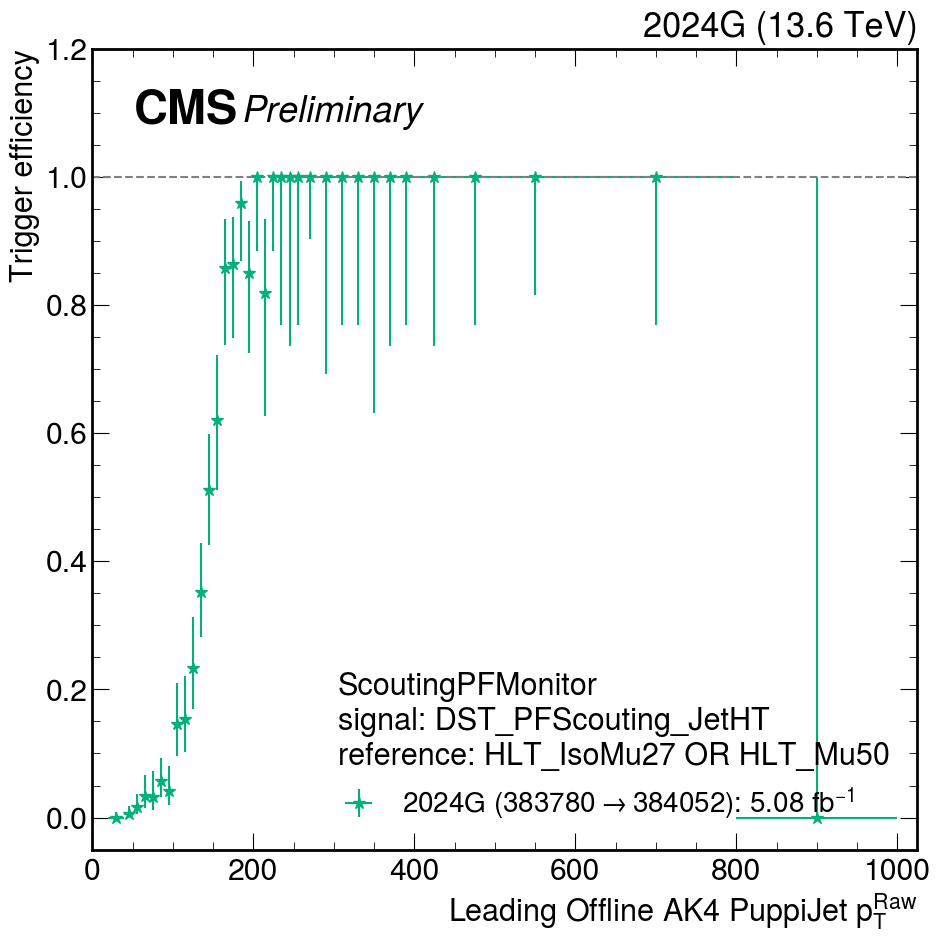

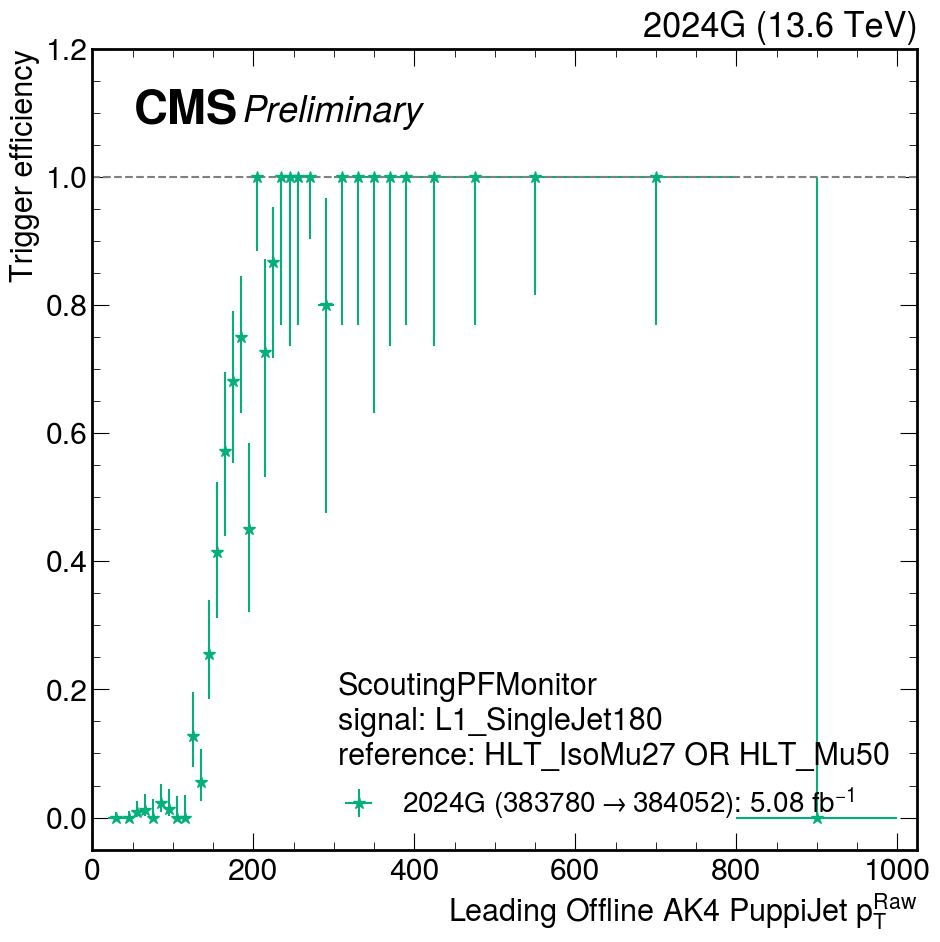

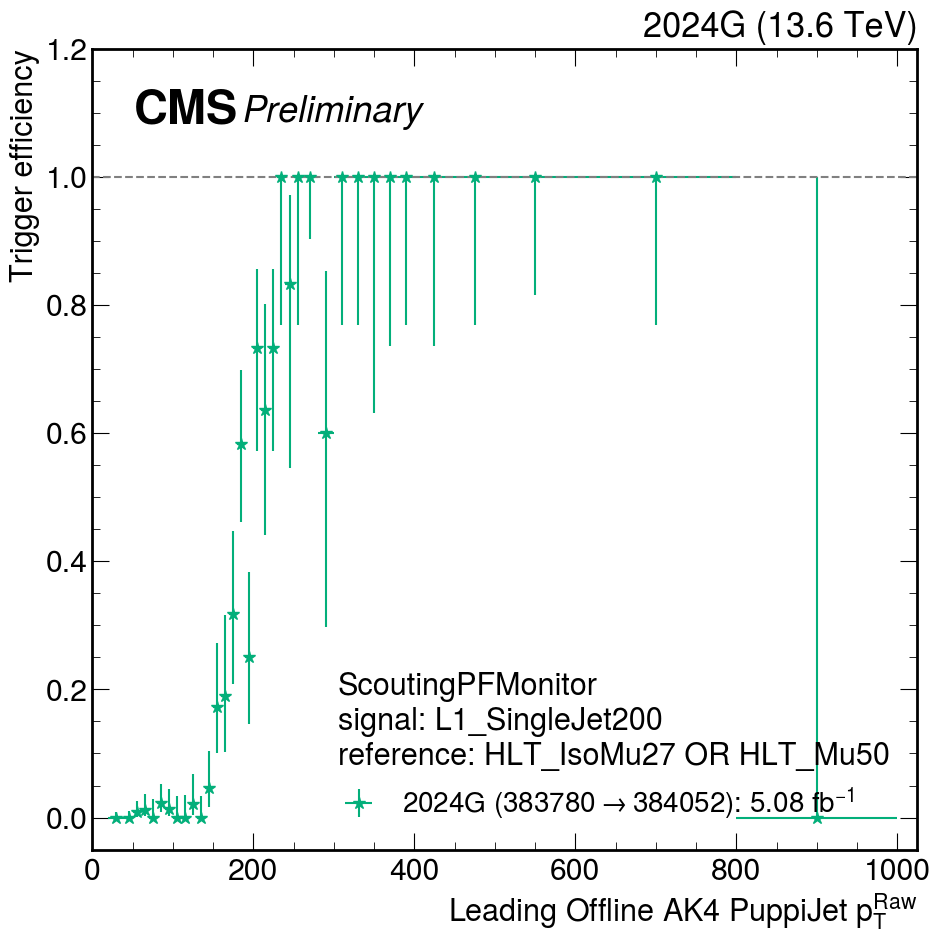

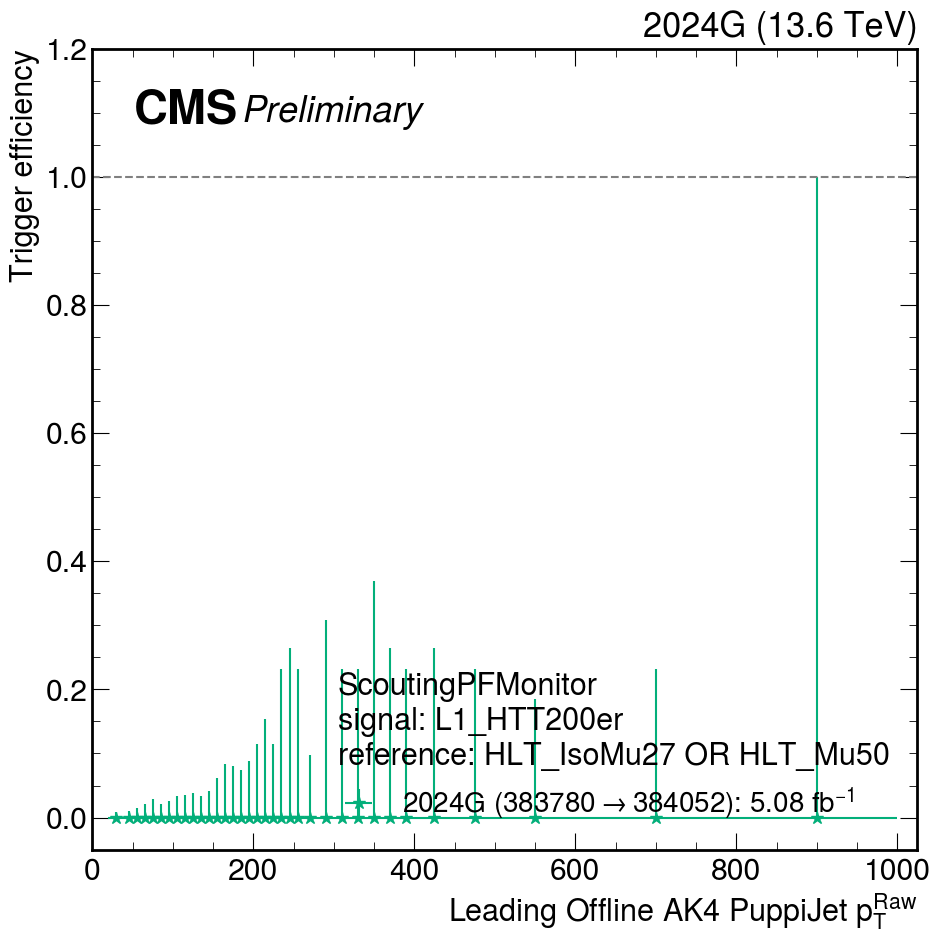

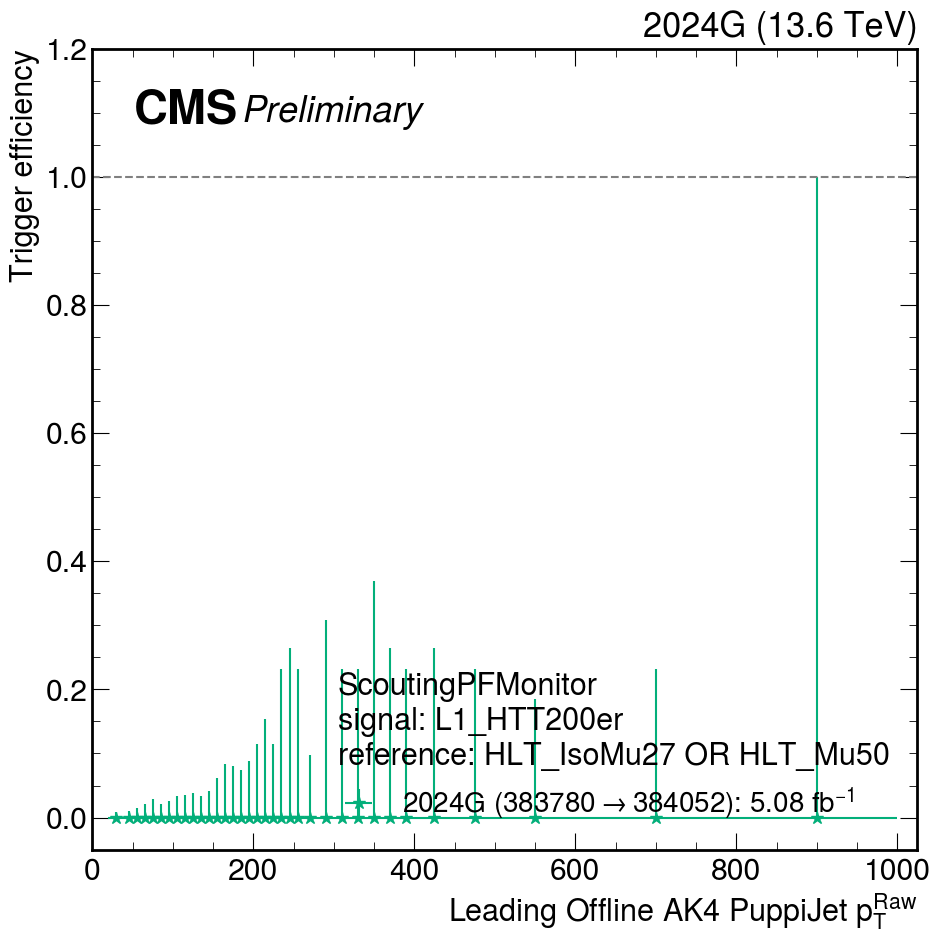

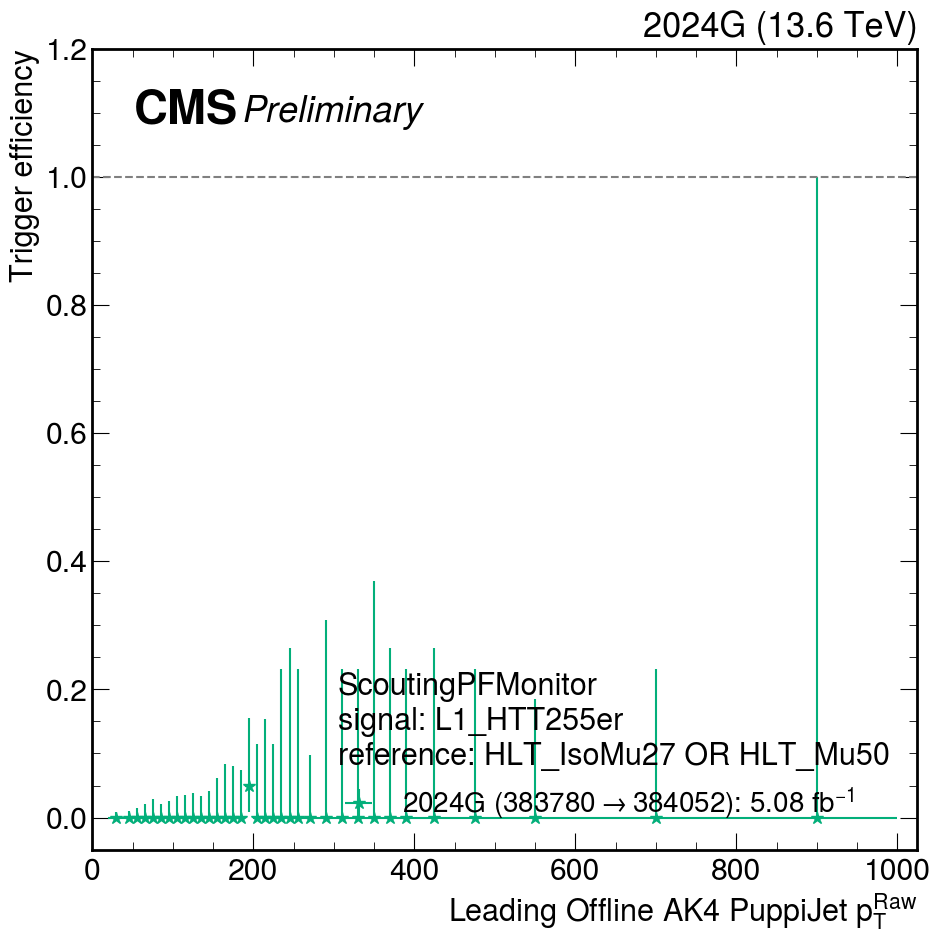

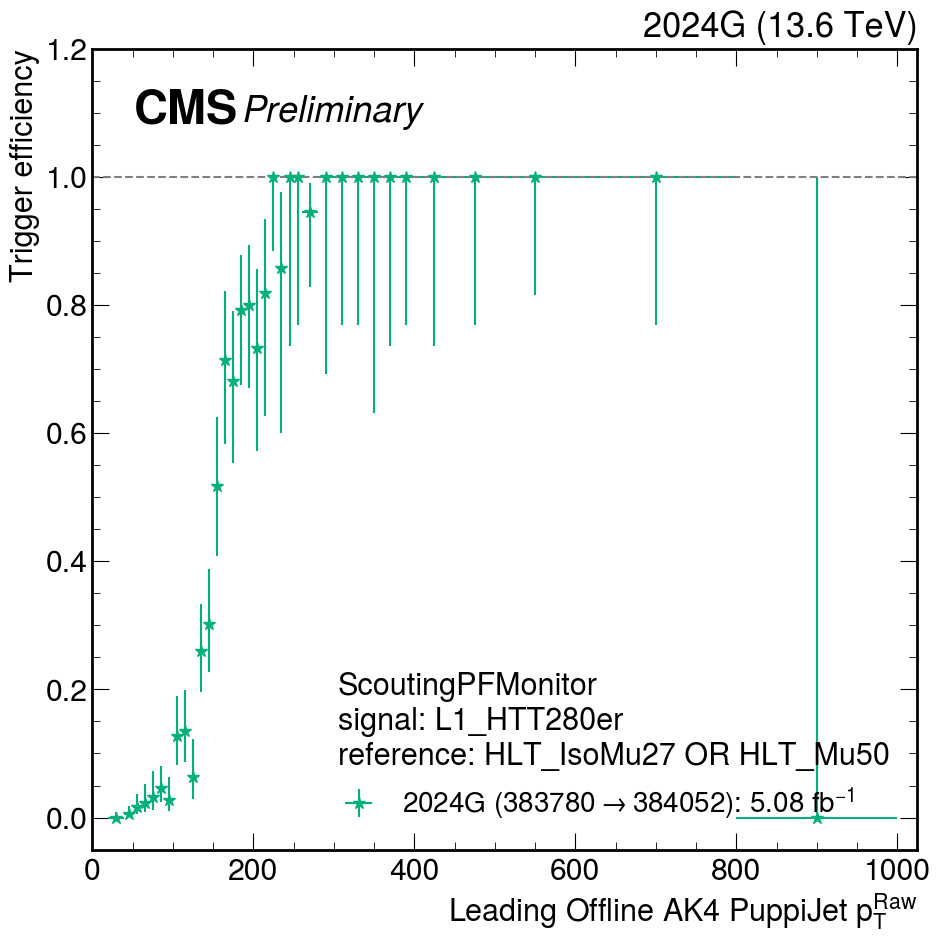

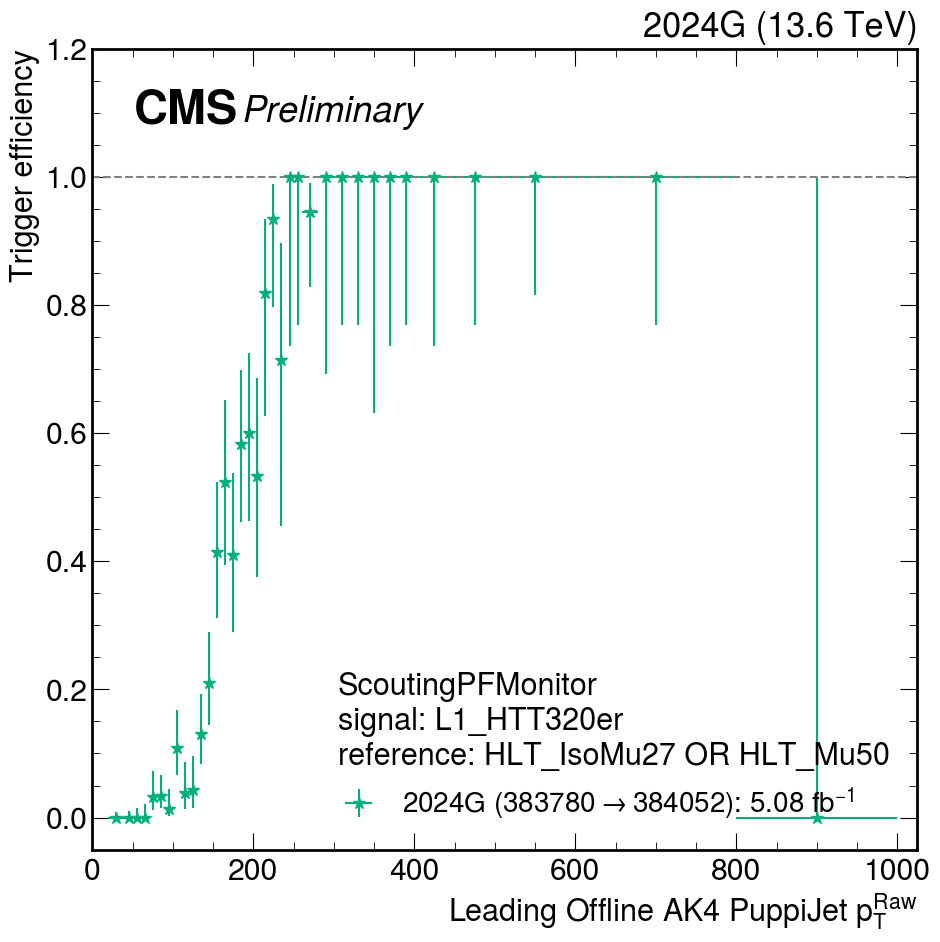

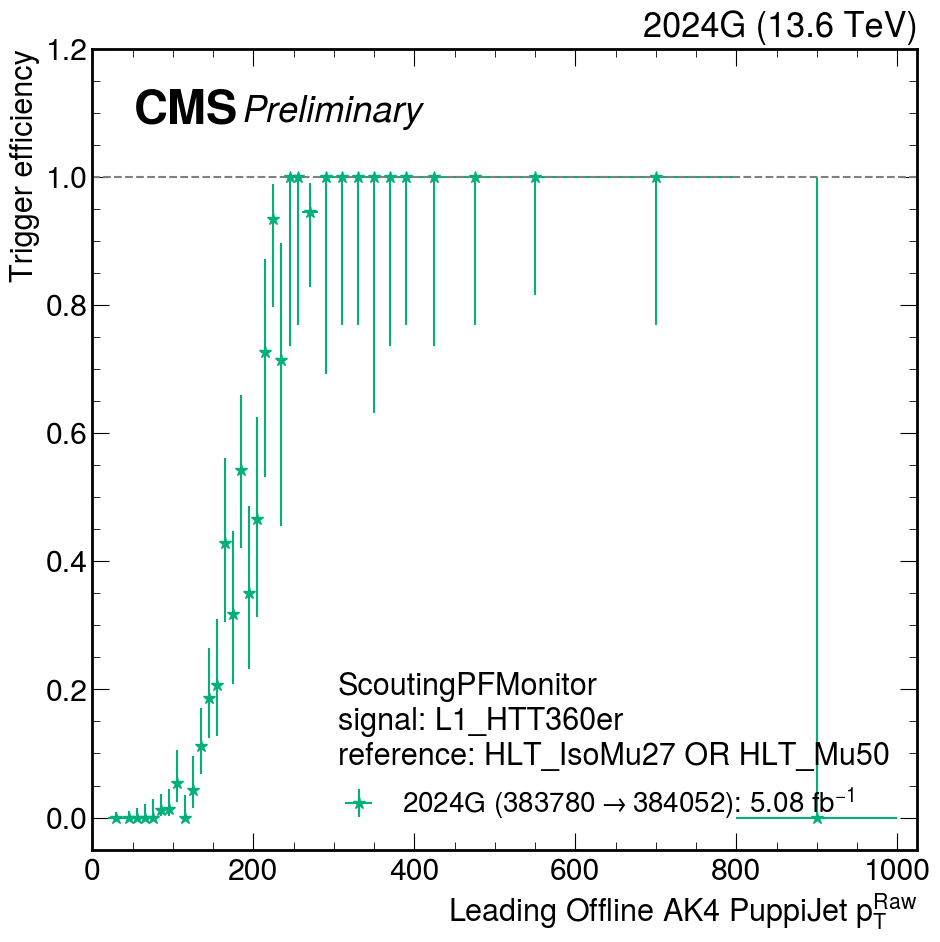

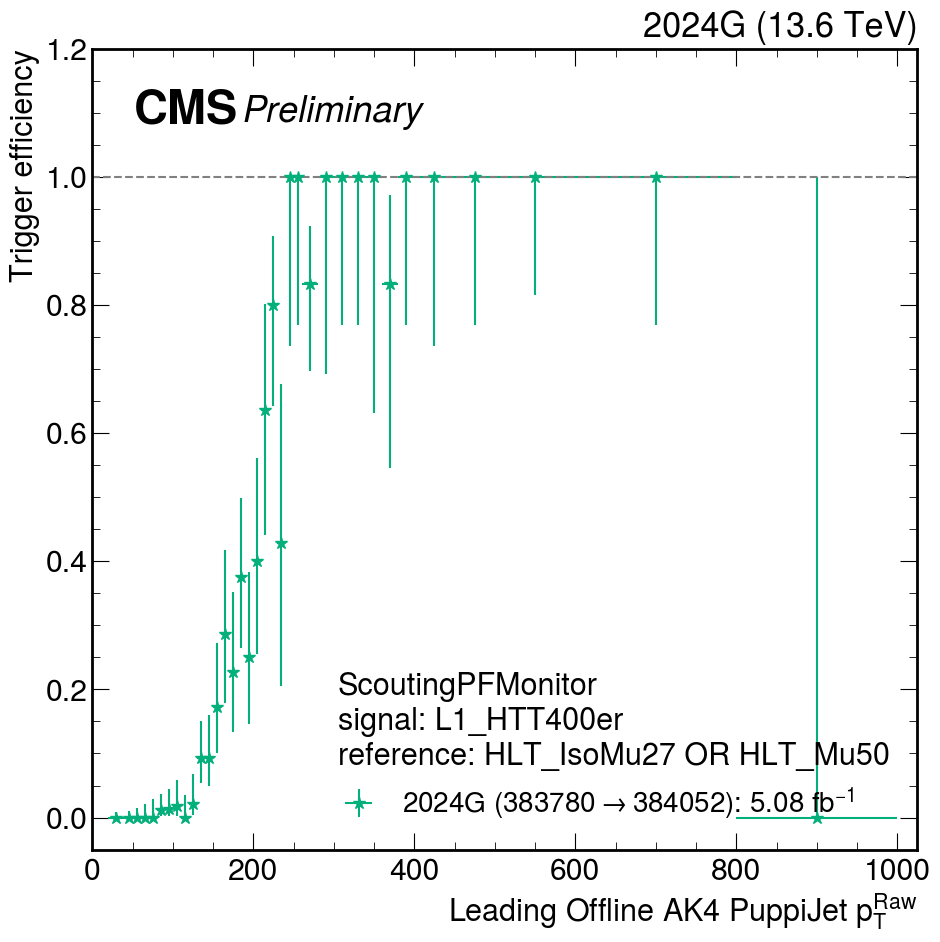

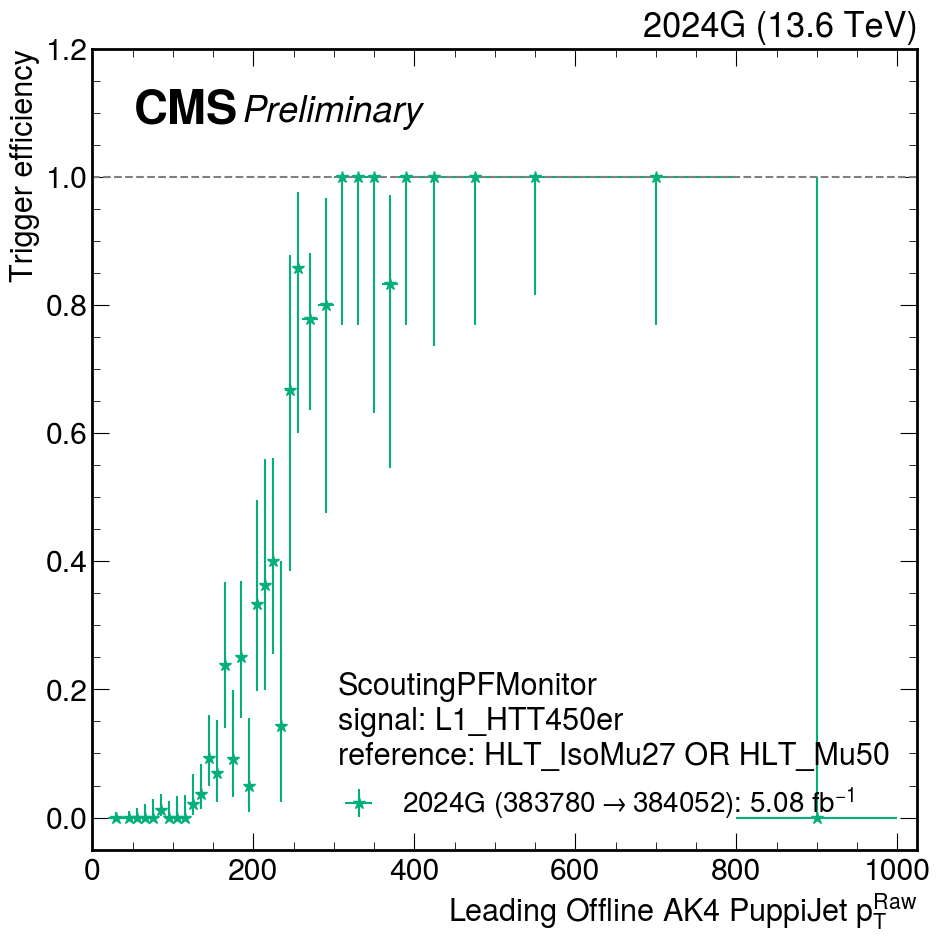

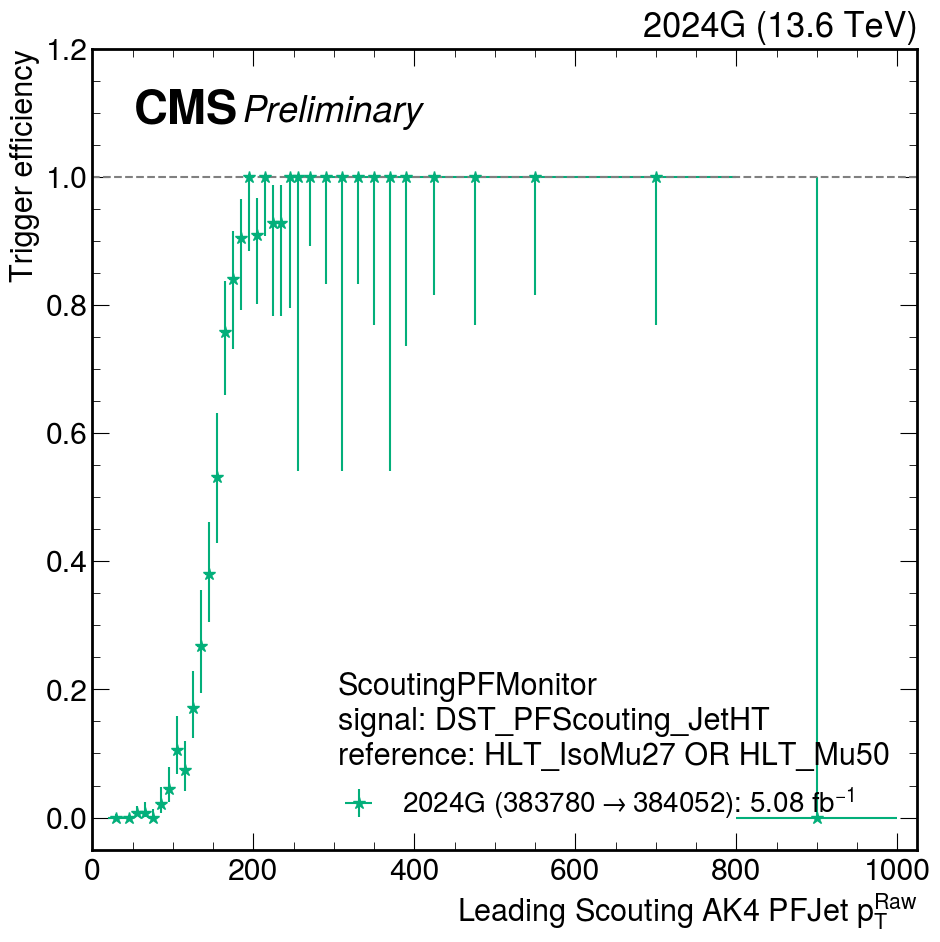

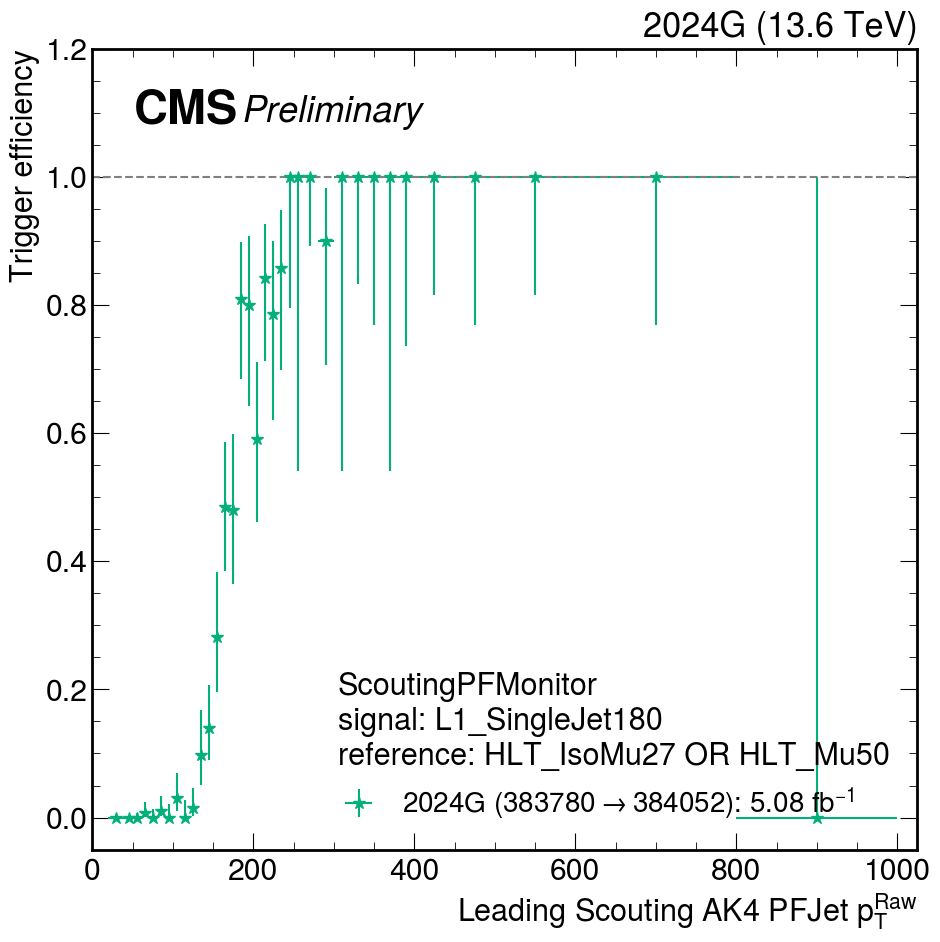

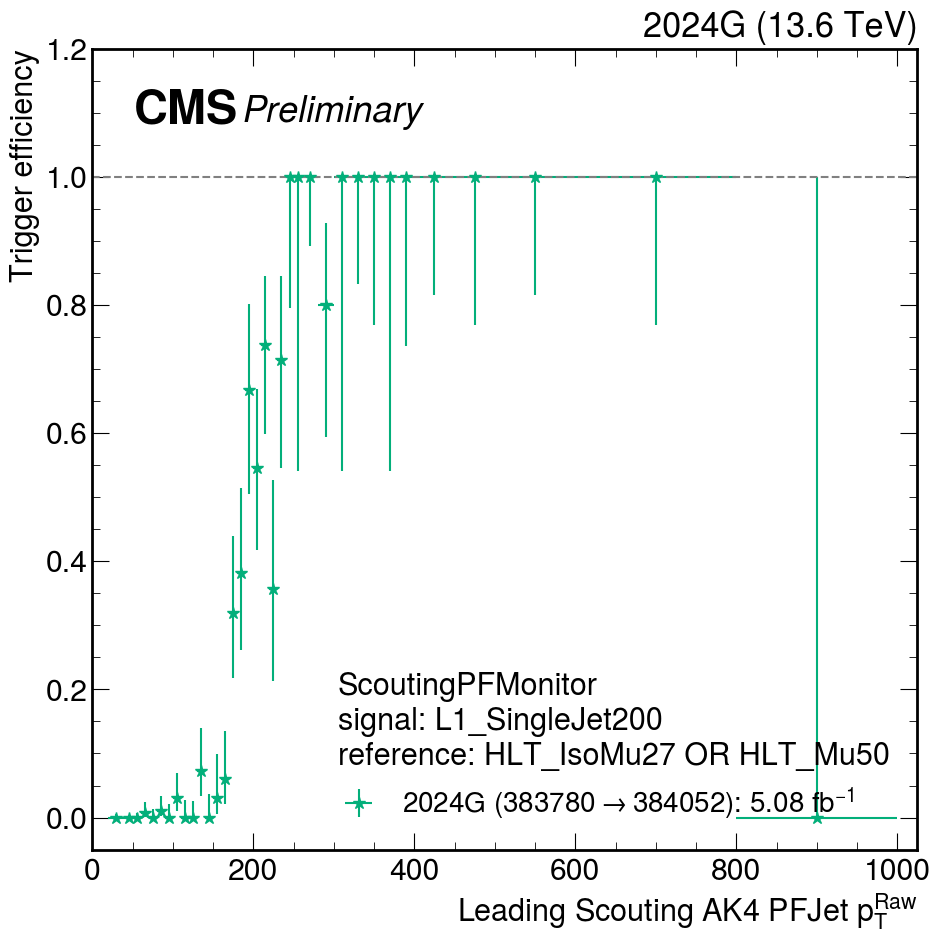

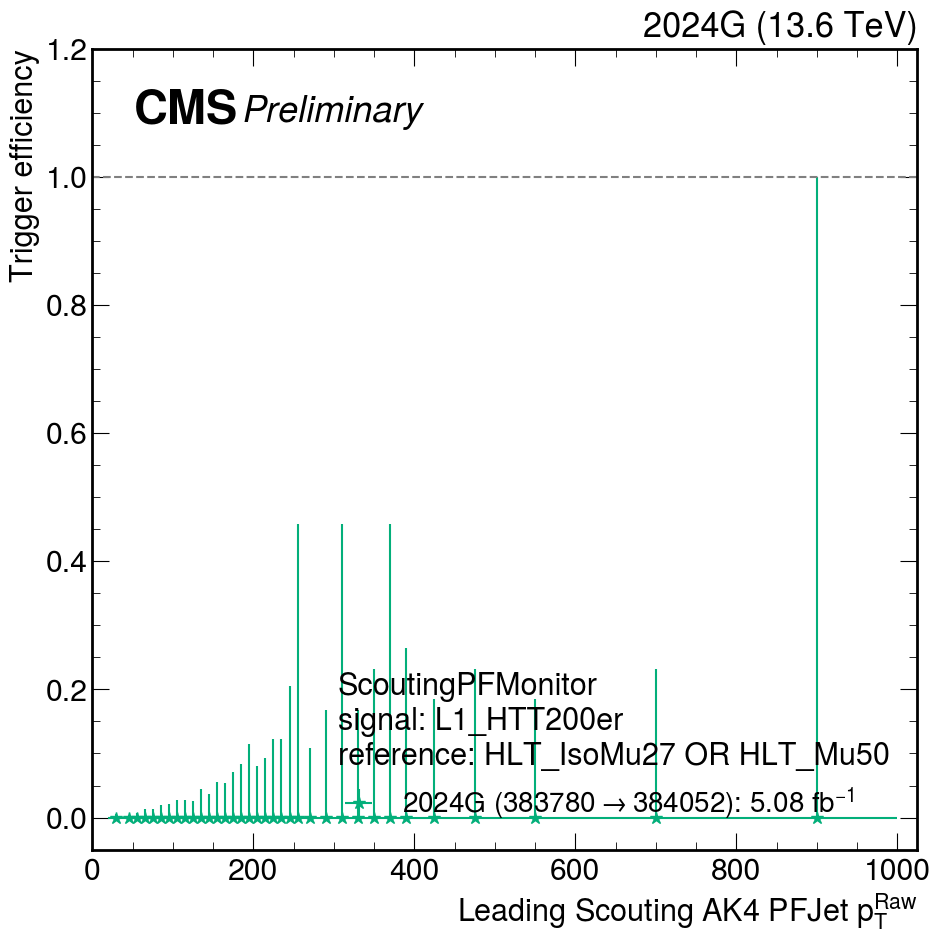

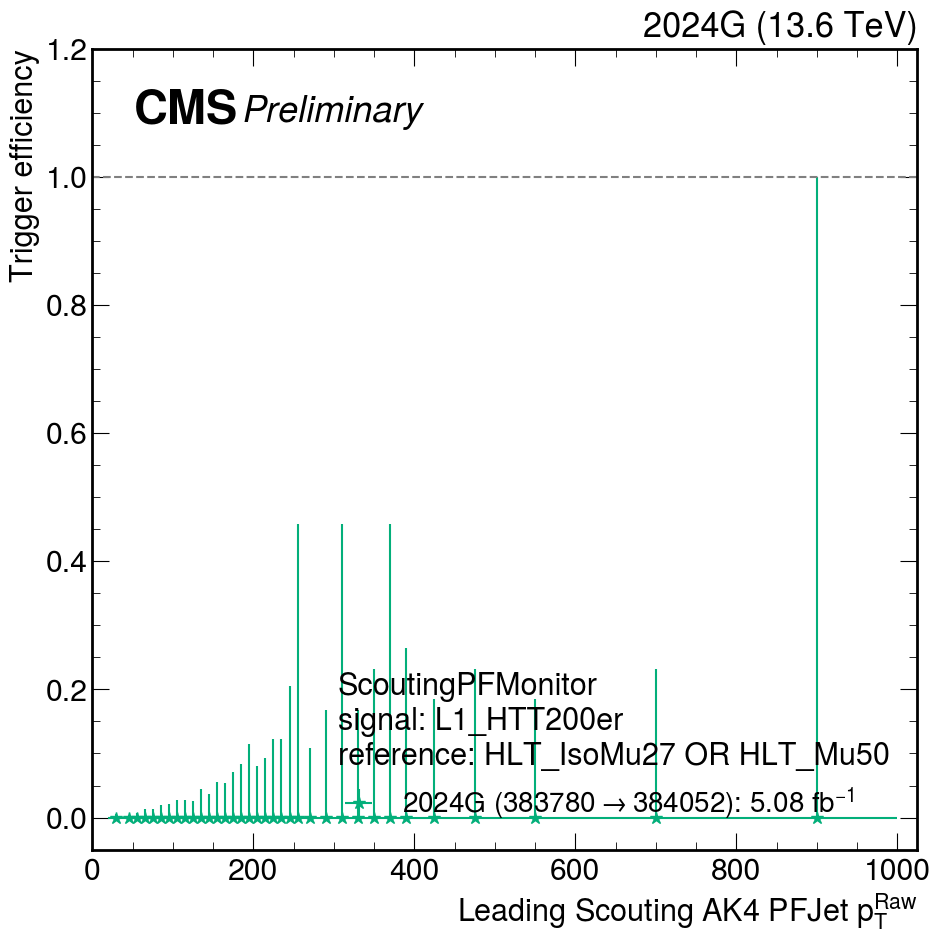

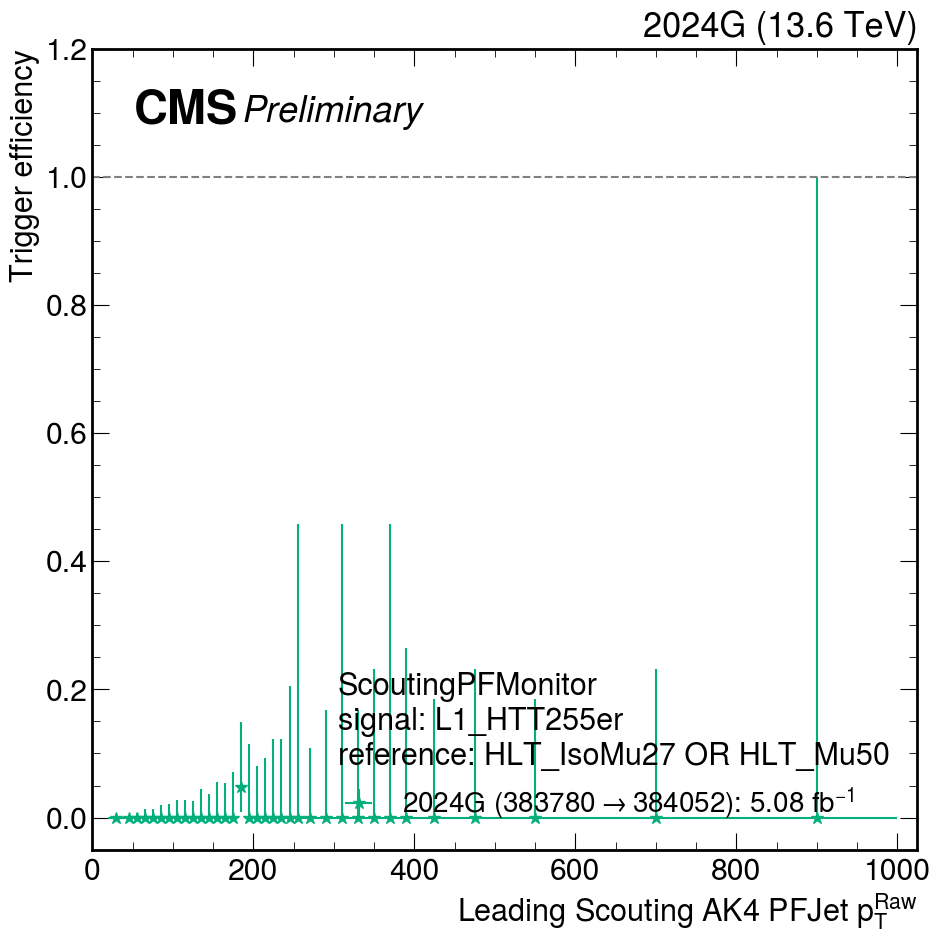

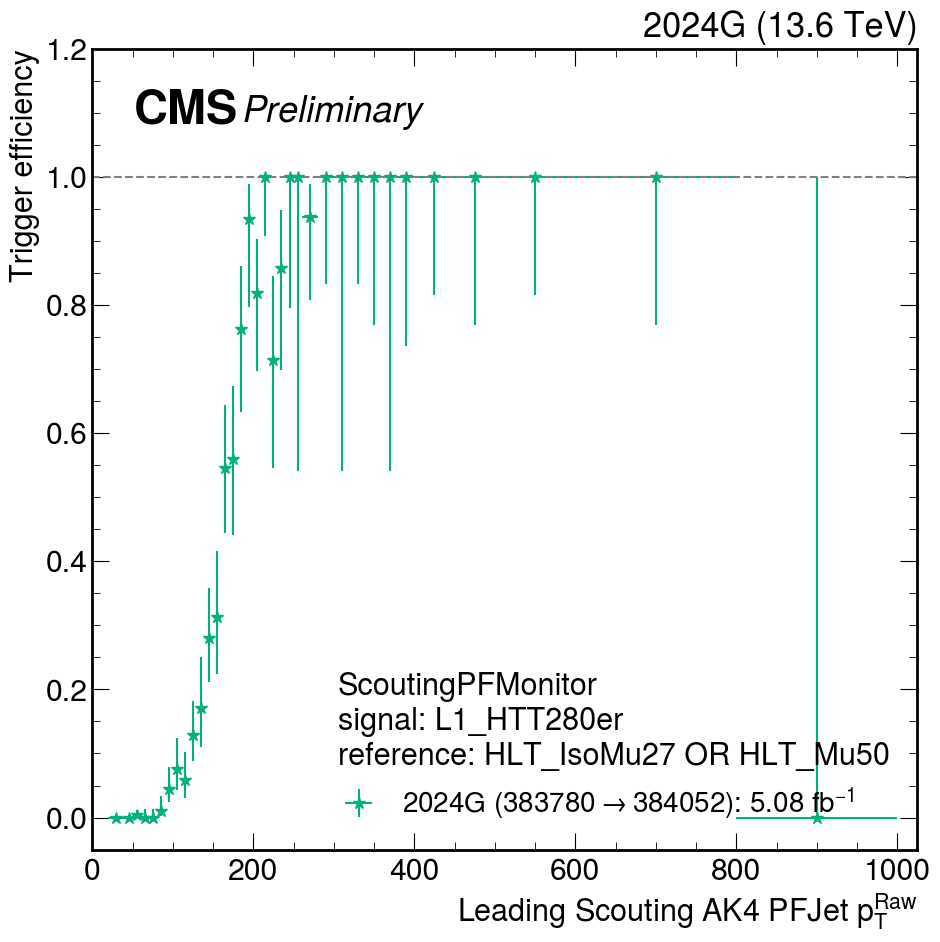

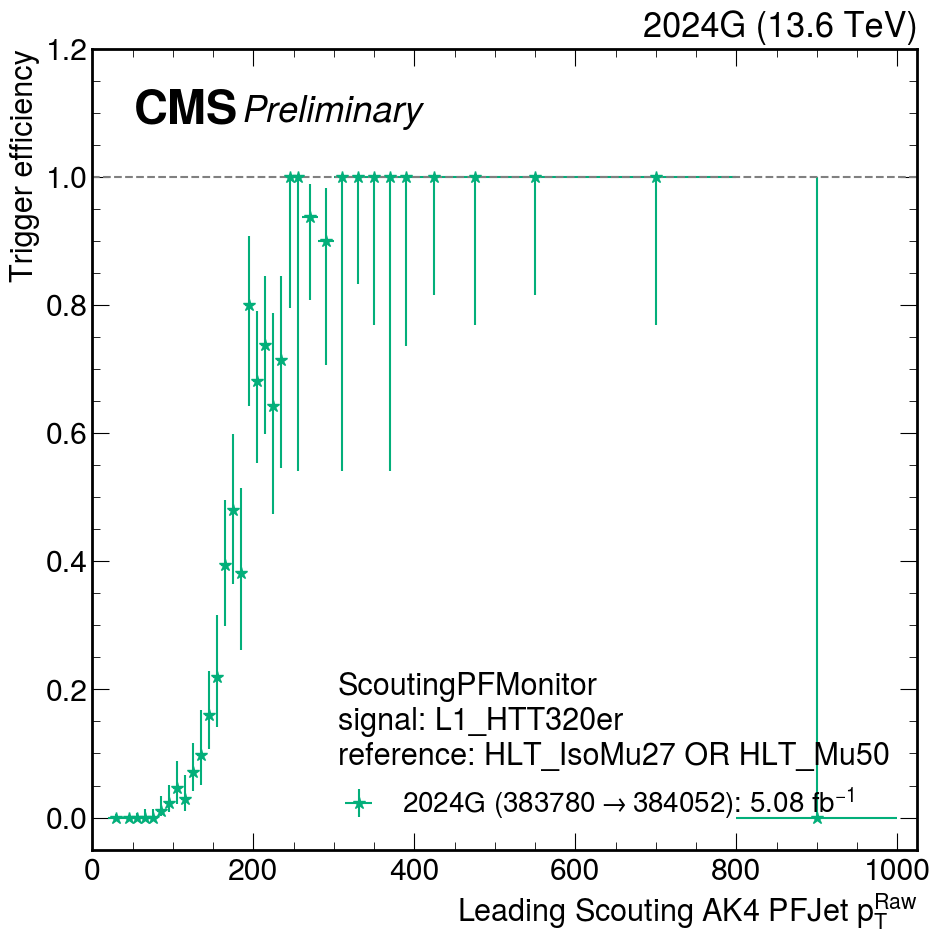

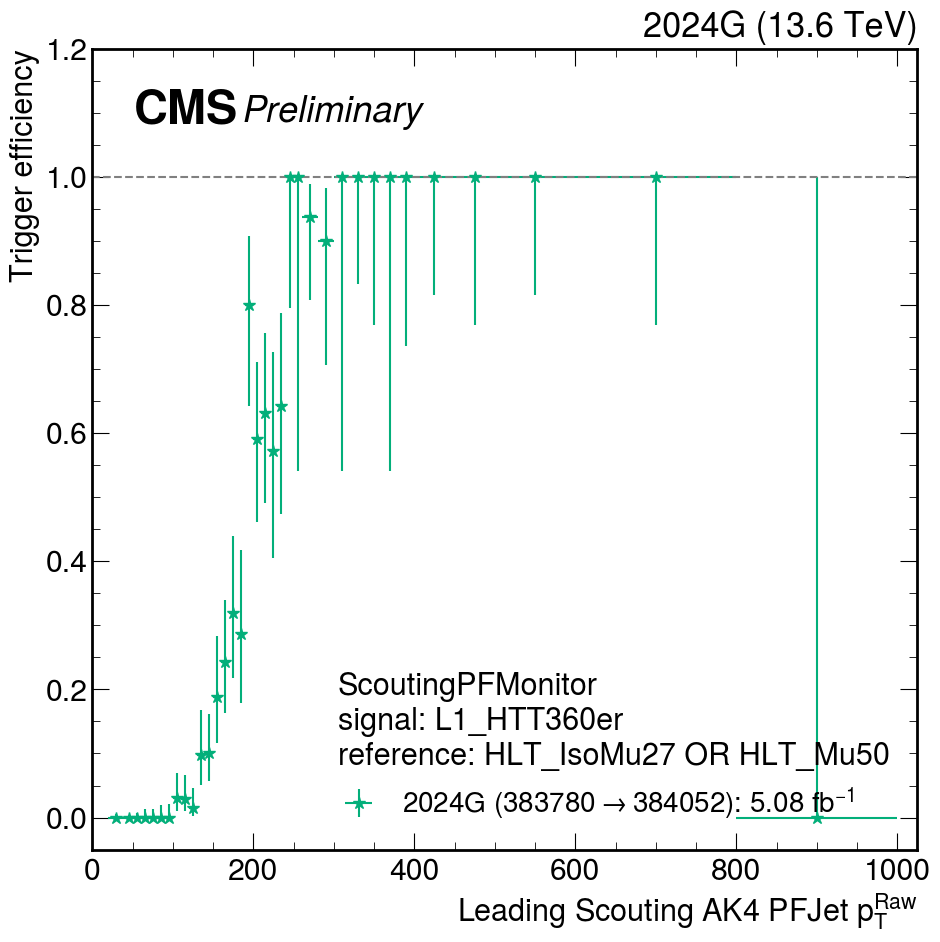

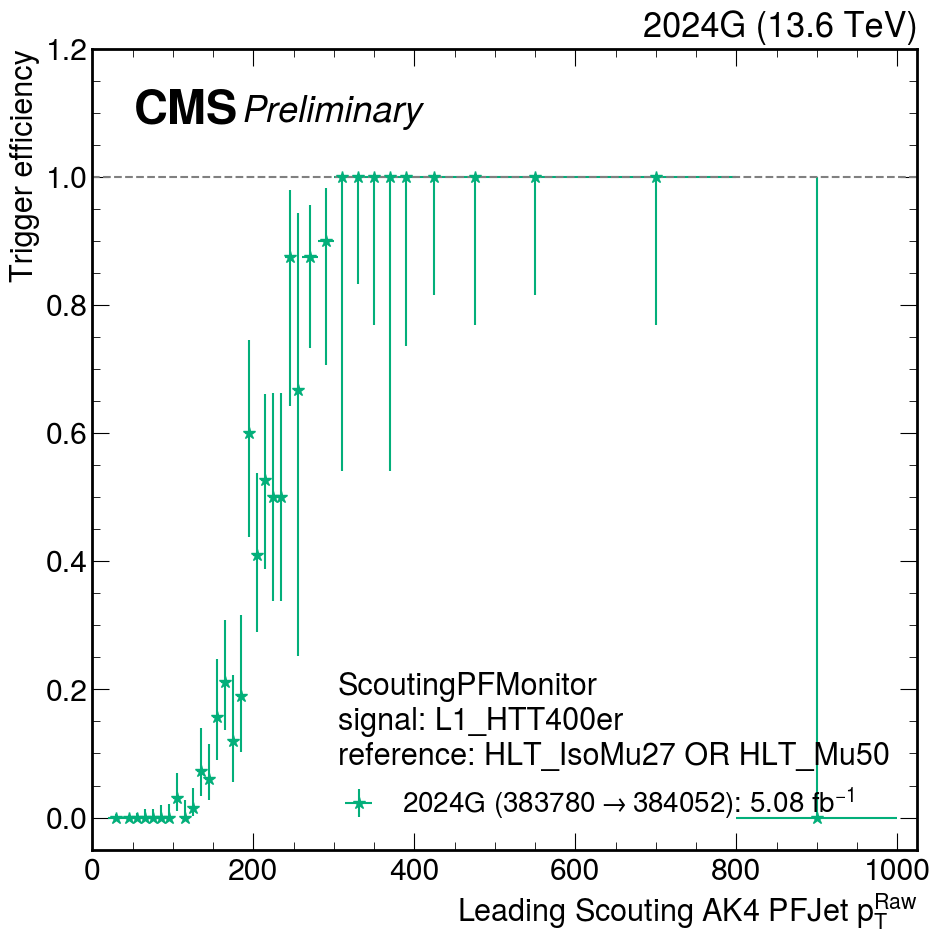

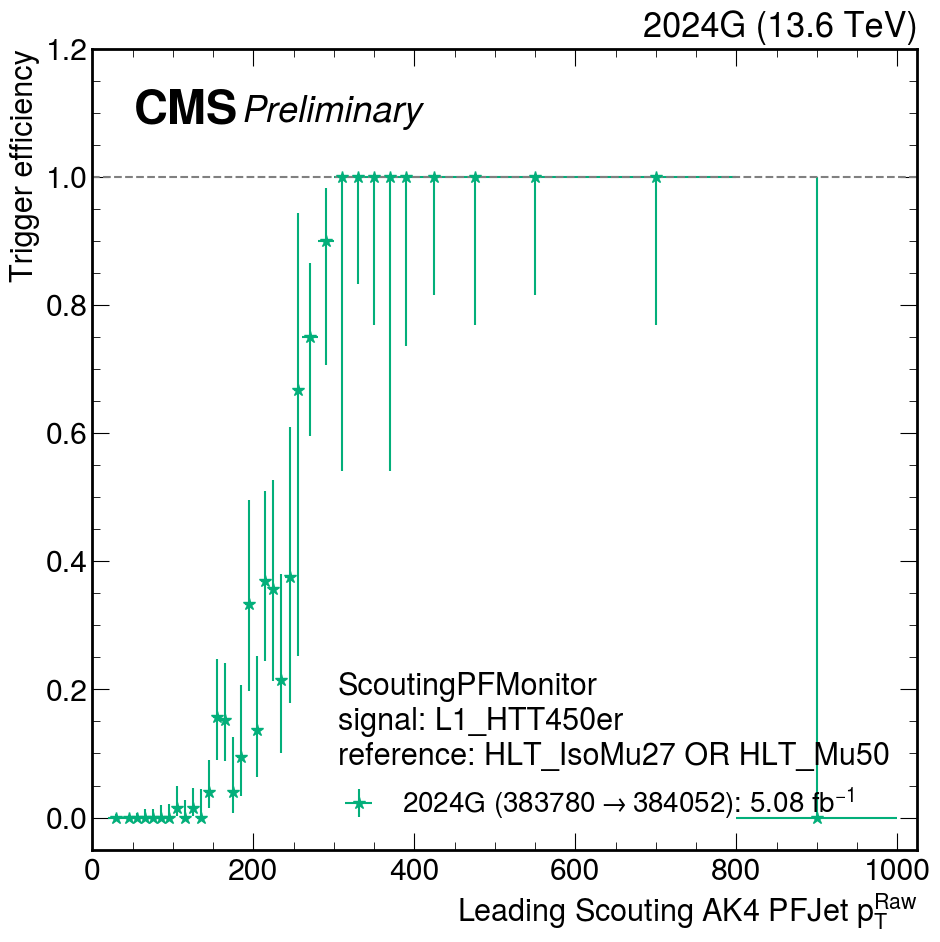

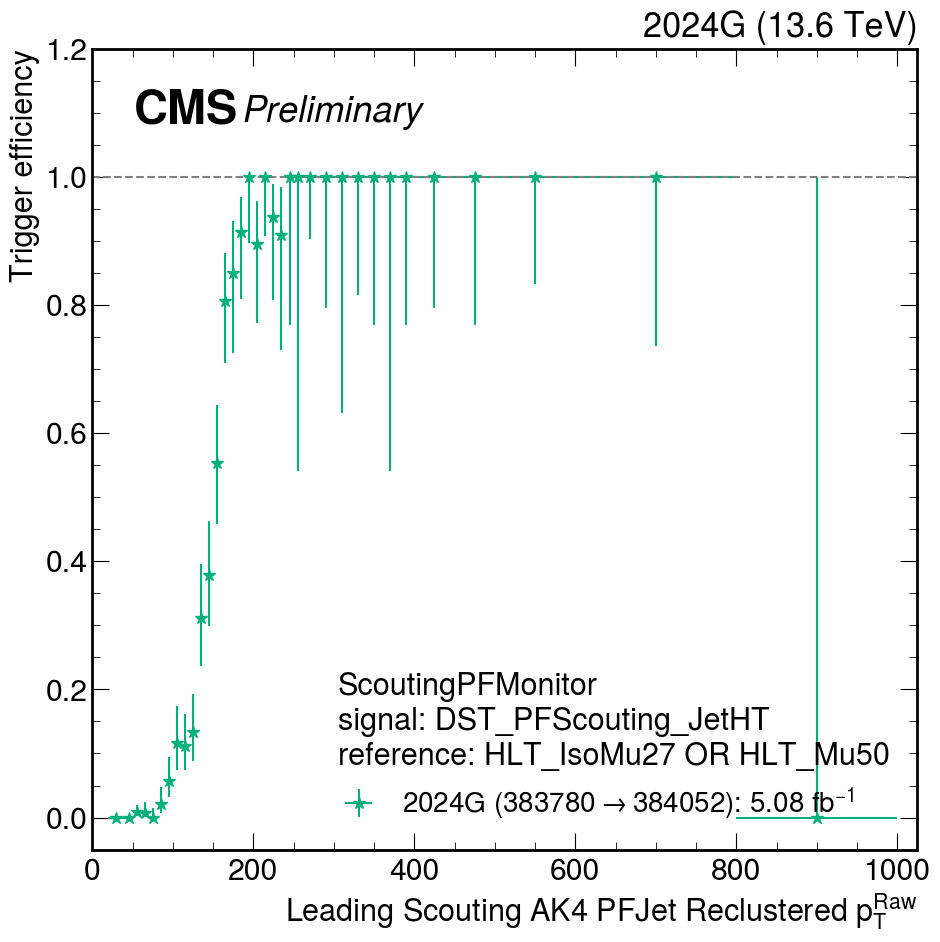

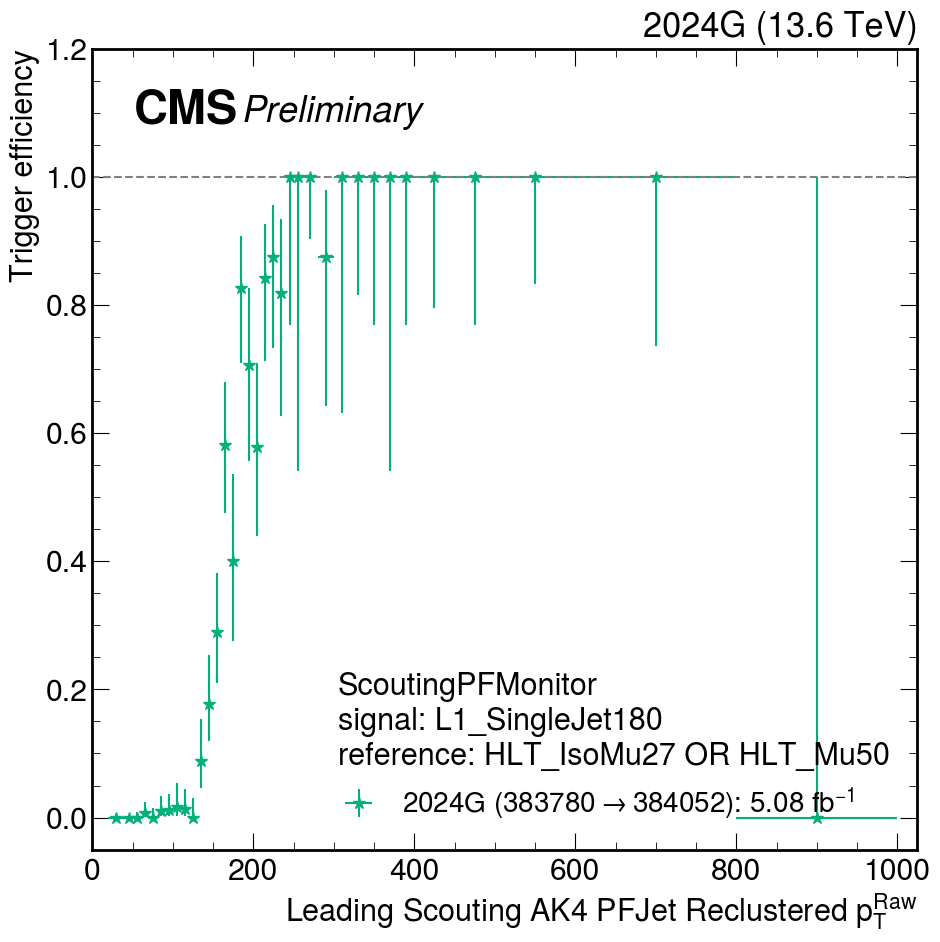

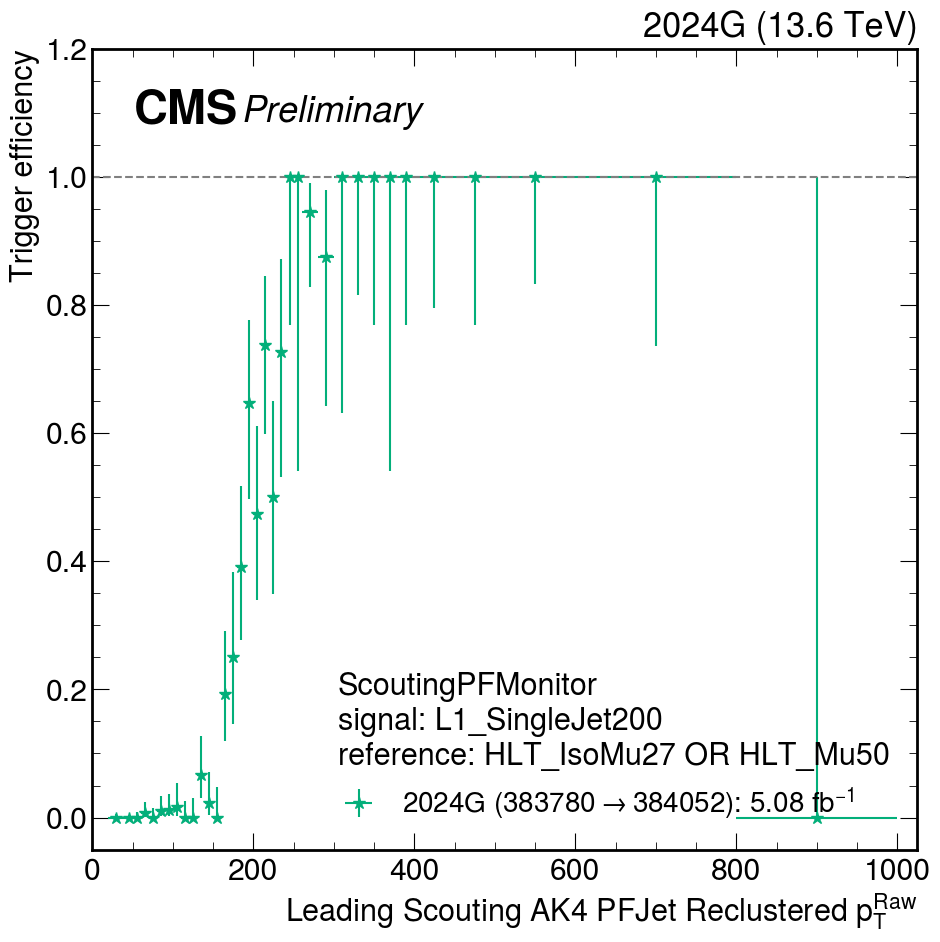

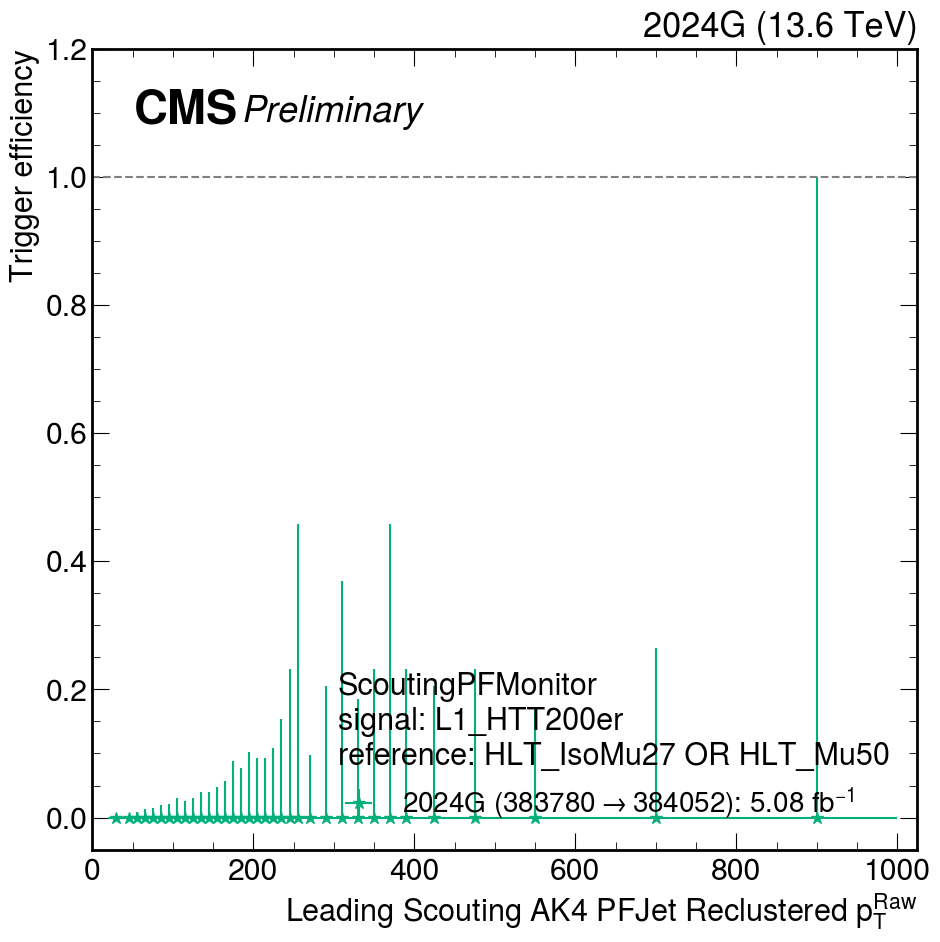

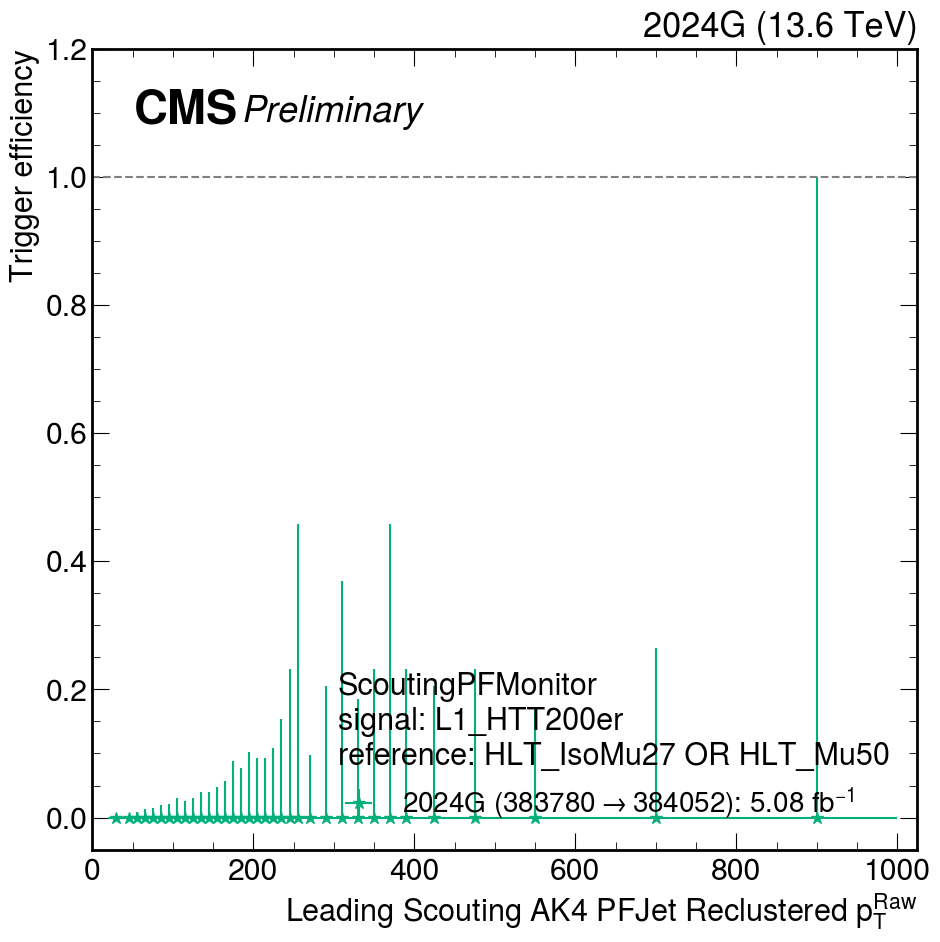

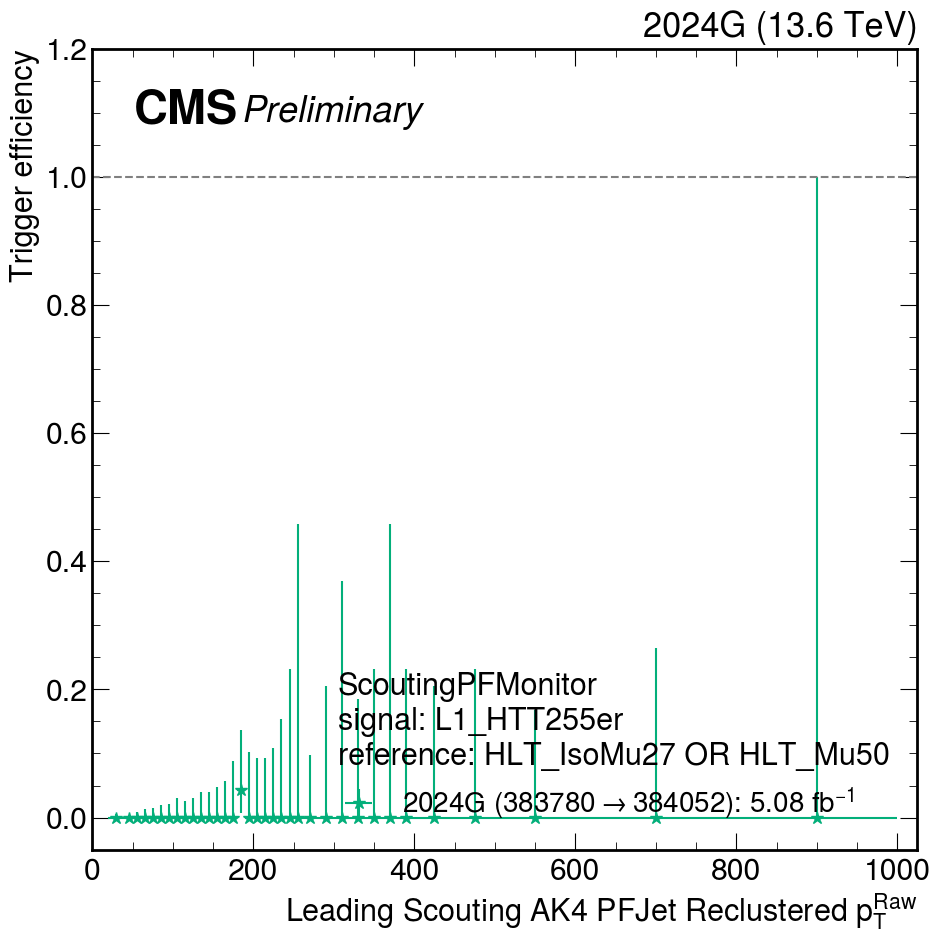

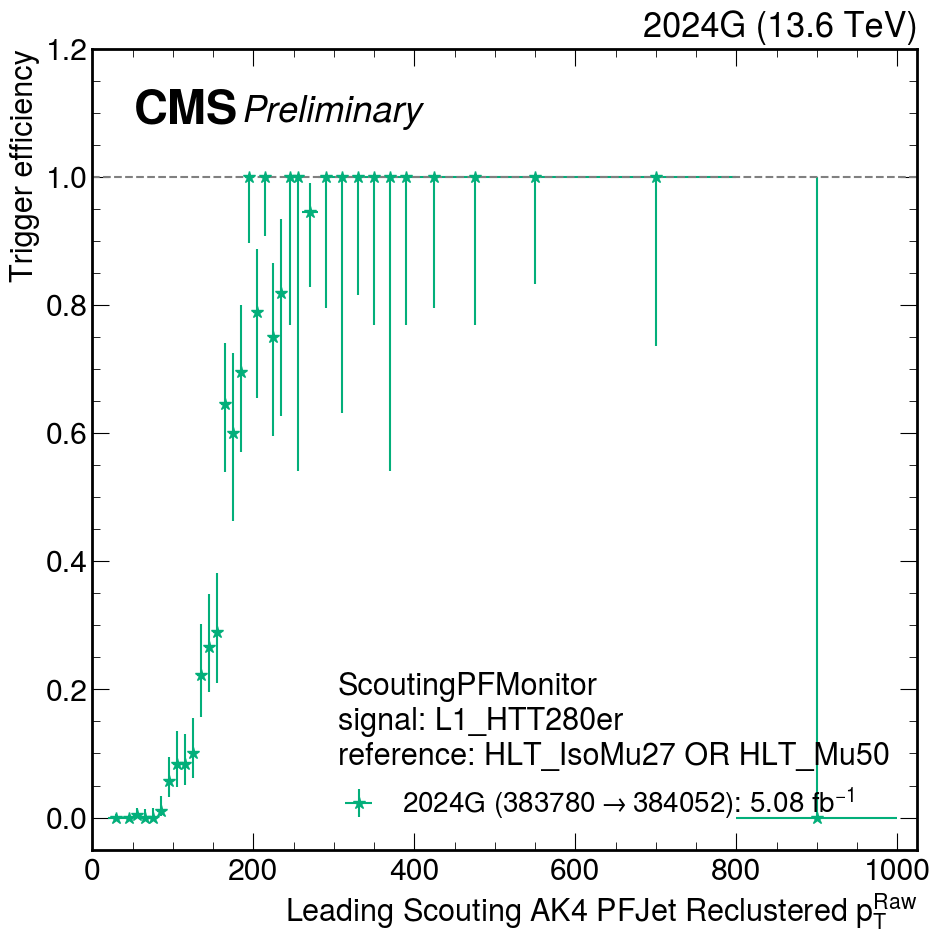

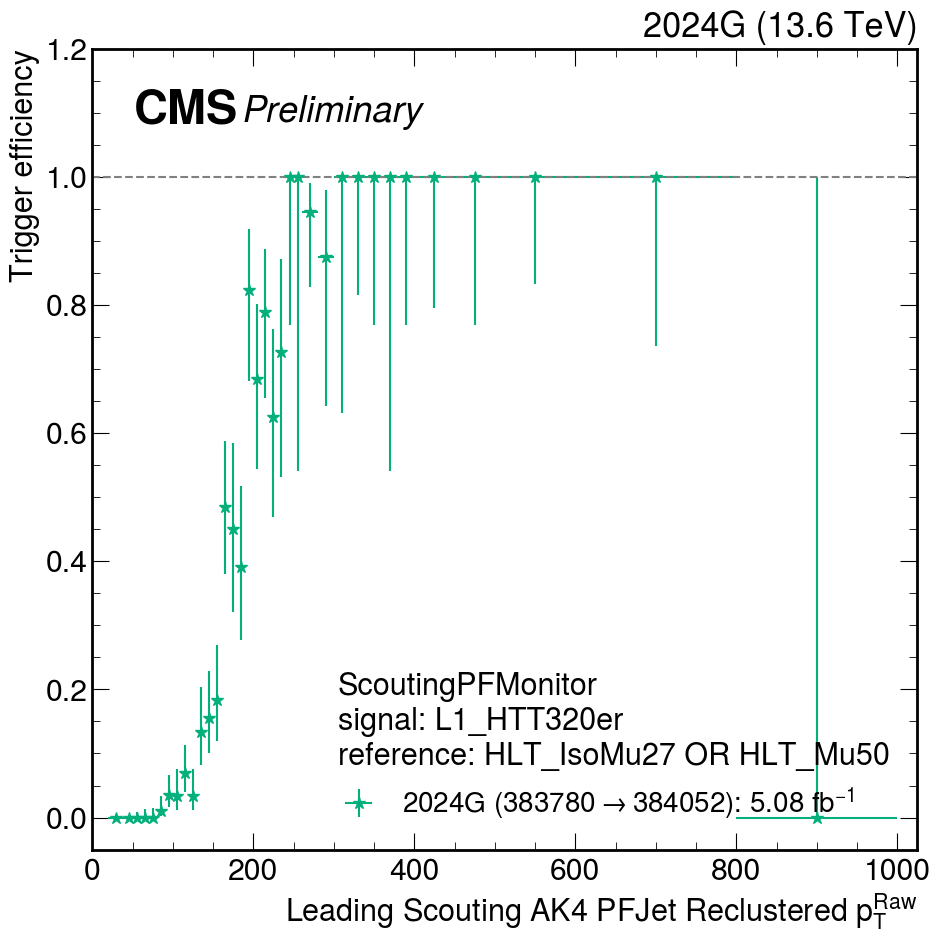

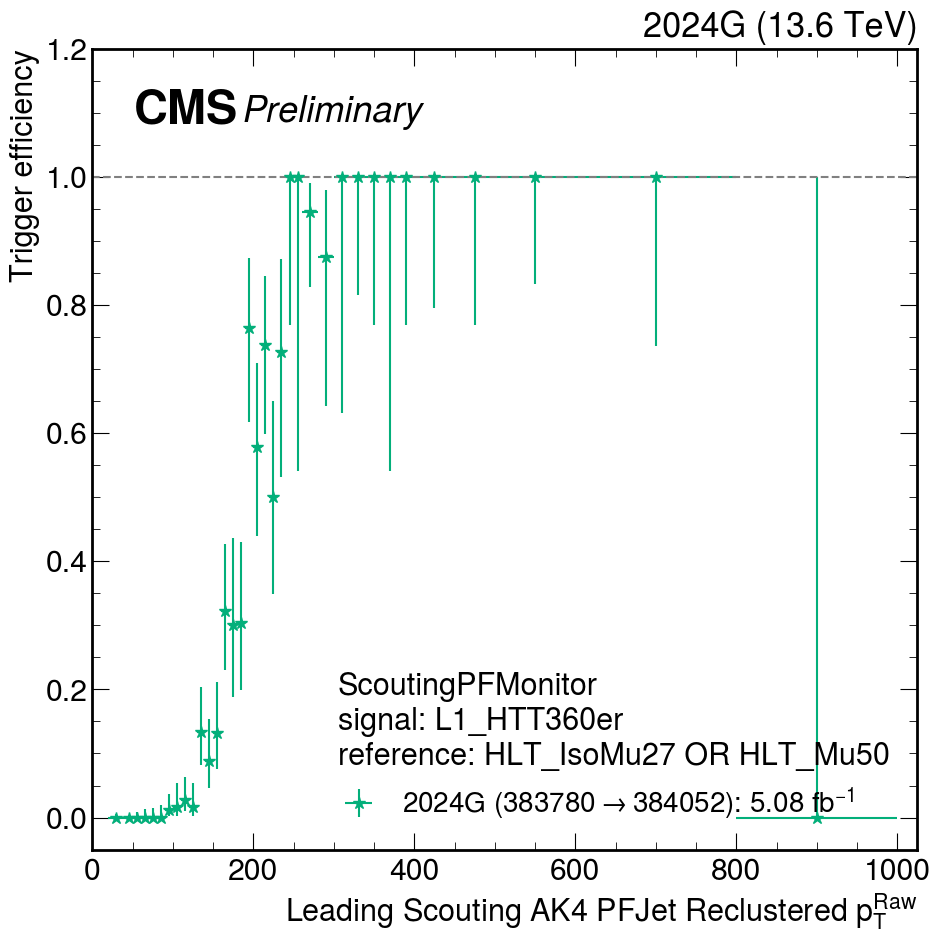

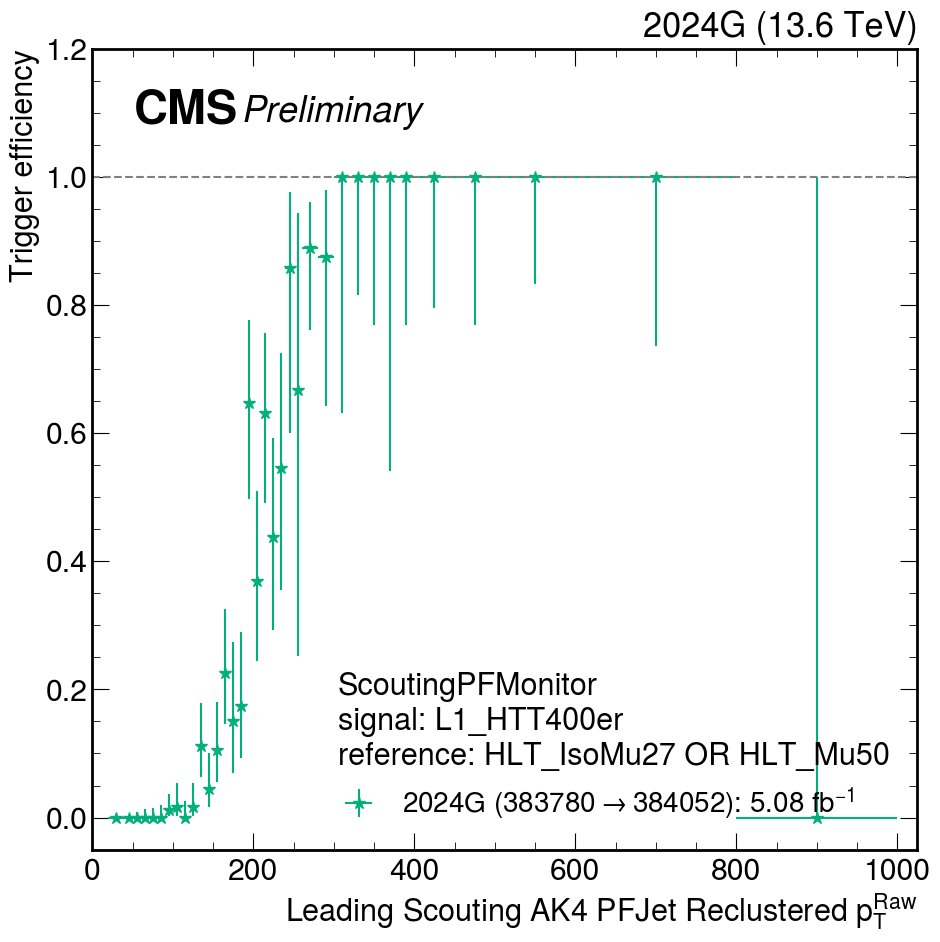

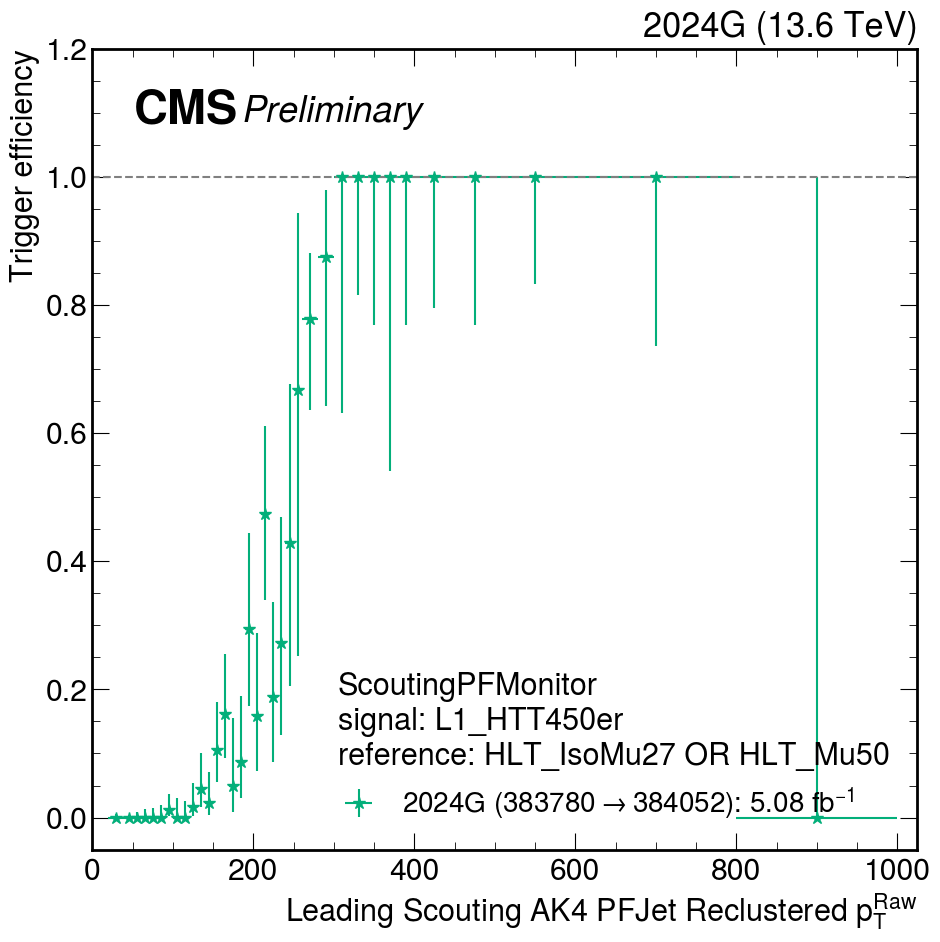

In [68]:
plot_datasets = [
    #"ScoutingPFMonitor_Run2024E",
    #"ScoutingPFMonitor_Run2024F",
    "ScoutingPFMonitor_Run2024G",
]

plot_jet_types = [
    "Jet", "PFJet", "ScoutingPFJet", "ScoutingPFJetRecluster", "ScoutingCHSJetRecluster", 
]

#plot_jet_types = jet_type_format_dict.keys()

plot_jet_types = ["Jet", "ScoutingPFJet", "ScoutingPFJetRecluster"]

plot_hist = "h_jet"
plot_variables = [("pt", r"$p_T^{Raw}$")]#, ("ht", r"$H_T^{Uncorrected}$")]

for plot_var, plot_var_label in plot_variables:
    for jet_type in plot_jet_types:
        jet_type_format = jet_type_format_dict[jet_type]
        for trigger_task in trigger_tasks:
            fig, ax = plt.subplots()
            for dataset in plot_datasets:
                signal_trigger_name = trigger_task["signal"]["name"]
                reference_trigger_name = trigger_task["reference"]["name"]
                intersect_trigger_name = f"({signal_trigger_name}) AND ({reference_trigger_name})"
                h_numerator = out[dataset][plot_hist][{
                    "dataset": dataset,
                    "jet_type": jet_type,
                    "trigger": intersect_trigger_name,
                }].project(plot_var)
    
                h_denominator = out[dataset][plot_hist][{
                    "dataset": dataset,
                    "jet_type": jet_type,
                    "trigger": reference_trigger_name
                }].project(plot_var)
    
                count_numerator = h_numerator.values()
                count_denomerator = h_denominator.values()
    
                trigger_efficiency = np.where(count_denomerator!=0, count_numerator/count_denomerator, 0)
    
                cp_interval = clopper_pearson_interval(count_numerator, count_denomerator)
                trigger_efficiency_error = np.abs(cp_interval - trigger_efficiency)
    
                bin_centers = h_numerator.axes[plot_var].centers
                bin_widths = h_numerator.axes[plot_var].widths
    
                mask = (bin_centers > jet_type_format["bin_center_min"]) & (bin_centers < jet_type_format["bin_center_max"])
    
                ax.errorbar(x=bin_centers[mask], 
                        y=trigger_efficiency[mask], 
                        xerr=(bin_widths/2)[mask],
                        yerr=trigger_efficiency_error[:, mask],
                        linestyle="",
                        fillstyle="full",
                        **format_dict[dataset])
    
                ax.set_xlim(*jet_type_format["xlim"])
    
            ax.legend(title=f"ScoutingPFMonitor\nsignal: {signal_trigger_name}\nreference: {reference_trigger_name}", loc=4, title_fontsize=22, fontsize=20, alignment="left")
            ax.set_ylabel("Trigger efficiency", fontsize=22)
            ax.set_xlabel(f"Leading {jet_type_format['label']} " + plot_var_label, fontsize=22)
            ax.set_ylim(-0.05, 1.2)
            ax.axhline(1.0, linestyle="dashed", color="gray")
    
            hep.cms.label(ax=ax, **hep_args)
    
            fig.tight_layout()
        #fig.savefig(f"plots/Trigger/TriggerEfficiency_EF_{jet_type}_{plot_var}.png", 
        #            bbox_inches="tight", dpi=300)